In [2]:
import pandas as pd
import numpy as np
import pyodbc as py

from datetime import date, timedelta, datetime
import time
import math

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.feature_selection import chi2, SelectKBest, SelectPercentile, mutual_info_classif, RFE, RFECV, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn import neighbors
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from imblearn.over_sampling import SMOTE
from itertools import product

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope
from time import time

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

import json
from numpyencoder import NumpyEncoder

import functions
import importlib
importlib.reload(functions)

import warnings
import random
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

#### Load Data

In [6]:
importlib.reload(functions)

<module 'functions' from '/Users/LV/Documents/GitHub/Seminar-QM-BA/functions.py'>

In [29]:
df = pd.read_csv('/Users/LV/Desktop/data_bol_complete.csv', low_memory = True)

In [30]:
df['orderDate']                   = pd.to_datetime(df['orderDate'])
df['cancellationDate']            = pd.to_datetime(df['cancellationDate'])
df['promisedDeliveryDate']        = pd.to_datetime(df['promisedDeliveryDate'])
df['shipmentDate']                = pd.to_datetime(df['shipmentDate'])
df['dateTimeFirstDeliveryMoment'] = pd.to_datetime(df['dateTimeFirstDeliveryMoment'])
df['startDateCase']               = pd.to_datetime(df['startDateCase'])
df['returnDateTime']              = pd.to_datetime(df['returnDateTime'])
df['registrationDateSeller']      = pd.to_datetime(df['registrationDateSeller'])

In [4]:
#Calculate totals per Match Determinant
totalCase = df['caseDays'].count()
totalReturn = df['returnDays'].count()
totalCancel = df['cancellationDays'].count()
totalPromisedDelivery = df['promisedDeliveryDays'].count()
totalDelivery = df['actualDeliveryDays'].count()

In [5]:
#Create table for plot
periodTable = pd.concat([df['caseDays'].value_counts().sort_index(),
                         df['returnDays'].value_counts().sort_index(),
                         df['cancellationDays'].value_counts().sort_index(),
                         df['promisedDeliveryDays'].value_counts().sort_index(),
                         df['actualDeliveryDays'].value_counts().sort_index()],axis=1)

In [6]:
#Create percantages per day and calculate running sum
periodTable['caseDays%'] = (periodTable['caseDays'] / totalCase).cumsum()
periodTable['returnDays%'] = (periodTable['returnDays'] / totalReturn).cumsum()
periodTable['cancellationDays%'] = (periodTable['cancellationDays'] / totalCancel).cumsum()
periodTable['promisedDeliveryDays%'] = (periodTable['promisedDeliveryDays'] / totalPromisedDelivery).cumsum()
periodTable['actualDeliveryDays%'] = (periodTable['actualDeliveryDays'] / df.shape[0]).cumsum()

In [291]:
col = periodTable['actualDeliveryDays%']
for i in range(30):
    if i < 13:
        print((i,round(col[i]*100,1)), end = '')
    else:
        print((i,64.2), end = '')

(0, 0.7)(1, 28.2)(2, 50.0)(3, 57.6)(4, 61.5)(5, 62.9)(6, 63.5)(7, 63.8)(8, 64.0)(9, 64.0)(10, 64.1)(11, 64.2)(12, 64.2)(13, 64.2)(14, 64.2)(15, 64.2)(16, 64.2)(17, 64.2)(18, 64.2)(19, 64.2)(20, 64.2)(21, 64.2)(22, 64.2)(23, 64.2)(24, 64.2)(25, 64.2)(26, 64.2)(27, 64.2)(28, 64.2)(29, 64.2)

In [284]:
periodTable

,caseDays,returnDays,cancellationDays,promisedDeliveryDays,actualDeliveryDays,caseDays%,returnDays%,cancellationDays%,promisedDeliveryDays%,actualDeliveryDays%
0.0,10221.0,1037.0,4639.0,34537.0,35338.0,0.062187,0.003696,0.195796,0.007236,0.007404
1.0,20425.0,34083.0,6940.0,1699249.0,1310846.0,0.186459,0.125180,0.488710,0.363252,0.282044
2.0,22459.0,42638.0,2638.0,1319161.0,1041357.0,0.323106,0.277158,0.600051,0.639635,0.500223
3.0,19048.0,35268.0,1522.0,592789.0,363063.0,0.438999,0.402866,0.664289,0.763833,0.576290
4.0,16078.0,28205.0,1577.0,433153.0,183553.0,0.536822,0.503399,0.730849,0.854584,0.614747
5.0,12818.0,22366.0,1806.0,297018.0,68269.0,0.614810,0.583119,0.807074,0.916814,0.629050
6.0,9714.0,17796.0,1240.0,34360.0,27708.0,0.673913,0.646551,0.859410,0.924013,0.634856
7.0,7836.0,15306.0,1021.0,170636.0,14698.0,0.721589,0.701107,0.902503,0.959763,0.637935
8.0,5623.0,11760.0,929.0,60228.0,7583.0,0.755801,0.743024,0.941713,0.972382,0.639524
9.0,4301.0,9360.0,508.0,34774.0,4443.0,0.781970,0.776386,0.963154,0.979668,0.640455


In [31]:
#Fixed Columns:
DATE = ['orderDate']
BASIC = ['totalPrice','quantityOrdered','fulfilmentByBol','countryCodeNL','countryOriginNL','countryOriginBE',
        'countryOriginDE','productTitleLength','promisedDeliveryDays','partnerSellingDays', 'orderCorona']
WEEK = ['orderMonday','orderTuesday','orderWednesday','orderThursday','orderFriday','orderSaturday','orderSunday']
MONTH = ['orderJanuary','orderFebruary','orderMarch','orderApril','orderMay','orderJune',
         'orderJuly','orderAugust','orderSeptember','orderOctober','orderNovember','orderDecember']
YEAR = ['orderYear2020']
GROUP = ['groupHealth','groupHome','groupSports','groupComputer','groupPets','groupToys','groupBooks', 
         'groupBaby', 'groupMusic', 'groupFood','groupOffice','groupFashion','groupOther','groupCar']

#Dynamic Columns:
TRANSPORTERX = ['transporterPOSTNL/X','transporterDHL/X','transporterDPD/X','transporterBRIEF/X','transporterOTHER/X']
KNOWNX = ['caseKnownX','returnKnownX','cancellationKnownX','onTimeDeliveryKnownX','lateDeliveryKnownX']
PRODUCTX = ['productOrderCountX','productTotalCountX','productTotalReturnedX','productReturnFractionX']
SELLERX = ['sellerDailyOrdersX']
HISTORICX = []
historic_variable = ['transporterCode','sellerId','productGroup']
for x in range(len(historic_variable)):
    HISTORICX = HISTORICX + [historic_variable[x]+'HistoricHappyX',historic_variable[x]+'HistoricUnhappyX',historic_variable[x]+'HistoricUnknownX']

#Determinants:
DETERMINANT = ['noReturn', 'noCase', 'noCancellation', 'onTimeDelivery']

#Classifications
CLASSIFICATION = ['generalMatchClassification','detailedMatchClassification','binaryMatchClassification','determinantClassification']

In [32]:
X_col = BASIC + WEEK + MONTH + YEAR + GROUP + TRANSPORTERX + KNOWNX + PRODUCTX + SELLERX + HISTORICX
Y_col = ['detailedMatchClassification']

#### Sample data

In [196]:
df_ = df.sample(n = 100000, replace = False, random_state = 1)

#### Validation (Flat)

In [65]:
# df_ contains a sample of training + validation data
random.seed(100)
df_ = df.iloc[:int(0.8*len(df))].sample(n=1100000, replace=False, random_state=1).sort_values(by = 'orderDate').reset_index(drop = True)

In [44]:
def flat_get_hyperspace(combination):
    
    param_hyperopt = {}

    if combination == 'DT':
        hyper = {'DT_criterion'   : hp.choice('DT_criterion',['gini','entropy']),
                 'DT_max_depth'   : scope.int(hp.quniform('DT_max_depth', 5, 15, 1))}
    elif combination == 'RF':
        hyper = {'RF_max_depth'    : scope.int(hp.quniform('RF_max_depth', 5, 15, 1)),
                 'RF_n_estimators' : scope.int(hp.quniform('RF_n_estimators', 10, 50, 5))}
    elif combination == 'NN':
        hyper = {'NN_dropout'  : hp.uniform('NN_dropout', 0, 0.5),
                 'NN_nodes'    : scope.int(hp.quniform('NN_nodes', 5, 50, 5)),
                 'NN_layers'   : scope.int(hp.quniform('NN_layers', 1, 2, 1))}
    elif combination == 'LR':
        hyper = {'LR_penalty' : hp.choice('LR_penalty', ['l1','l2'])}

    param_hyperopt = {**param_hyperopt, **hyper}
        
    return param_hyperopt

In [61]:
def flat_objective_function(params):
    
    if combination == 'RF':
        clf = RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = params['RF_max_depth'], n_estimators = params['RF_n_estimators'])
    elif combination == 'LR':
        print(params)
        clf = LogisticRegression(penalty = params['LR_penalty'], class_weight = 'balanced', solver = 'liblinear')
    
    clf = clf.fit(X_train,y_train)
    pred = clf.predict(X_val)
    
    precision, recall, f1, support = metrics.precision_recall_fscore_support(y_val, pred, average = 'weighted', beta = 1)
    accuracy = metrics.accuracy_score(y_val, pred)
    #cross validation score to be implemented?
    
    return {'loss': -f1, 'status': STATUS_OK, 'accuracy': accuracy}

In [58]:
def flat_hyperopt(param_space, X_train, y_train, X_val, y_val, num_eval):

    trials = Trials()

    best_param = fmin(flat_objective_function, 
                      param_space, 
                      algo = tpe.suggest, 
                      max_evals = num_eval, 
                      trials = trials,
                      rstate = np.random.RandomState(1))
    
    loss = [x['result']['loss'] for x in trials.trials]
    index_min_loss = loss.index(min(loss))
    accuracy_scores = [x['result']['accuracy'] for x in trials.trials]
    
    f1 = min(loss)*-1
    accuracy = accuracy_scores[index_min_loss]
    
    return best_param, f1, accuracy

In [59]:
#Lourens
begin, end = 6, 8
#Jim
#begin, end = 9, 10
#Thomas
#begin, end = 3, 5
#Mathilde
#begin, end = 0, 2

In [ ]:
output = {}

combinations = ['RF','LR']

for DAY in range(begin,end+1):
    
    X_preBurn, y_preBurn = functions.dataX(df_, DATE, X_col, Y_col, historic_variable, DAY)
    index = range(0, X_preBurn.shape[0])

    X_train_val = X_preBurn.iloc[int(0.1*len(X_preBurn)):]
    y_train_val = y_preBurn.iloc[int(0.1*len(y_preBurn)):]

    #X_train_val = X.iloc[0:int(0.75*len(X))]
    X_train = X_train_val.iloc[0:int(0.8*len(X_train_val))]
    X_val = X_train_val.iloc[int(0.8*len(X_train_val)):]

    #y_train_val = y.iloc[0:int(0.75*len(y))]
    y_train = y_train_val.iloc[0:int(0.8*len(y_train_val))]
    y_val = y_train_val.iloc[int(0.8*len(y_train_val)):]

    #X_test_full = X.iloc[int(0.75*len(X)):]
    #y_test_full = y.iloc[int(0.75*len(y)):]

    output[DAY] = {}

    for combination in combinations:
        
        if combination == 'RF':
            n_trials = 20
        elif combination == 'LR':
            n_trials = 2

        best_param, f1, accuracy = flat_hyperopt(flat_get_hyperspace(combination), X_train, y_train, X_val, y_val, n_trials)

        output[DAY][str(combination)] = (DAY, best_param, f1, accuracy)
        print(output)

        with open('/Users/LV/Desktop/flat_validation.json', 'w') as f:
            json.dump(output, f, cls = NumpyEncoder)

100%|██████████| 20/20 [20:33<00:00, 61.68s/trial, best loss: -0.8038906562402993]
{0: {'RF': (0, {'RF_max_depth': 14.0, 'RF_n_estimators': 45.0}, 0.8038906562402993, 0.7911010101010101)}}
{'LR_penalty': 'l1'}                                 
  0%|          | 0/2 [00:00<?, ?trial/s, best loss=?]

In [3]:
with open('/Users/LV/Desktop/Statistics/Flat/flat_validation_0_2.json') as f:
    val1 = json.load(f)
with open('/Users/LV/Desktop/Statistics/Flat/flat_validation_3_5.json') as f:
    val2 = json.load(f)
with open('/Users/LV/Desktop/Statistics/Flat/flat_validation_6_8.json') as f:
    val3 = json.load(f)
with open('/Users/LV/Desktop/Statistics/Flat/flat_validation_9_10.json') as f:
    val4 = json.load(f)

In [28]:
validation = {**val1, **val2, **val3, **val4}
validation = pd.DataFrame.from_dict(validation)
for i in range(11):
    validation[str(i)] = validation[str(i)].apply(lambda x: x[1])
validation

,0,1,2,3,4,5,6,7,8,9,10
RF,"{'RF_max_depth': 14.0, 'RF_n_estimators': 45.0}","{'RF_max_depth': 14.0, 'RF_n_estimators': 45.0}","{'RF_max_depth': 14.0, 'RF_n_estimators': 40.0}","{'RF_max_depth': 14.0, 'RF_n_estimators': 45.0}","{'RF_max_depth': 14.0, 'RF_n_estimators': 40.0}","{'RF_max_depth': 14.0, 'RF_n_estimators': 45.0}","{'RF_max_depth': 14.0, 'RF_n_estimators': 40.0}","{'RF_max_depth': 14.0, 'RF_n_estimators': 45.0}","{'RF_max_depth': 14.0, 'RF_n_estimators': 45.0}","{'RF_max_depth': 14.0, 'RF_n_estimators': 45.0}","{'RF_max_depth': 14.0, 'RF_n_estimators': 45.0}"
LR,{'LR_penalty': 0},{'LR_penalty': 0},{'LR_penalty': 0},{'LR_penalty': 0},{'LR_penalty': 0},{'LR_penalty': 0},{'LR_penalty': 1},{'LR_penalty': 0},{'LR_penalty': 0},{'LR_penalty': 0},{'LR_penalty': 0}


#### Validation (Static)

In [254]:
# df_ contains a sample of training + validation data
random.seed(100)
df_ = df.iloc[:int(0.8*len(df))].sample(n=1100000, replace=False, random_state=1).sort_values(by = 'orderDate').reset_index(drop = True)

In [255]:
df_.head()

,orderDate,productId,sellerId,totalPrice,quantityOrdered,countryCode,cancellationDate,cancellationReasonCode,promisedDeliveryDate,shipmentDate,transporterCode,transporterName,transporterNameOther,dateTimeFirstDeliveryMoment,fulfilmentType,startDateCase,cntDistinctCaseIds,returnDateTime,quantityReturned,returnCode,productTitle,brickName,chunkName,productGroup,productSubGroup,productSubSubGroup,registrationDateSeller,countryOriginSeller,currentCountryAvailabilitySeller,calculationDefinitive,noCancellation,onTimeDelivery,noCase,hasOneCase,hasMoreCases,noReturn,detailedMatchClassification,generalMatchClassification,caseDays,returnDays,cancellationDays,actualDeliveryDays,shipmentDays,partnerSellingDays,promisedDeliveryDays,orderYear,orderMonth,orderWeekday,orderCorona,orderMonday,orderTuesday,orderWednesday,orderThursday,orderFriday,orderSaturday,orderSunday,orderJanuary,orderFebruary,orderMarch,orderApril,orderMay,orderJune,orderJuly,orderAugust,orderSeptember,orderOctober,orderNovember,orderDecember,orderYear2020,productTitleLength,fulfilmentByBol,countryCodeNL,countryOriginNL,countryOriginBE,countryOriginDE,determinantClassification,binaryMatchClassification,transporterCodeGeneral,productGroupGeneral,groupHealth,groupHome,groupSports,groupComputer,groupPets,groupToys,groupBooks,groupBaby,groupMusic,groupFood,groupOffice,groupFashion,groupOther,groupCar
0,2019-01-01,9200000084842057,1003805,3.662279,1,BE,NaT,NaN,2019-01-03,2019-01-02,TNT,PostNL,NaN,2019-01-03 10:54:16,FBB,NaT,NaN,NaT,NaN,NaN,YONO Aroma Diffuser Luchtbevochtiger 400ml – V...,Oliediffusors (Niet-elektrisch),Aromadiffuser,Health PG,Ontspanning,Aromatherapie,2014-11-10,NL,NL,True,True,True,True,0.0,0.0,True,HAPPY,HAPPY,NaN,NaN,NaN,2.0,1.0,1513,2,2019,1,1,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,155,True,False,True,False,False,All good,KNOWN,POSTNL,Health & Care,True,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2019-01-01,9200000102226038,1377785,2.638343,1,NL,NaT,NaN,2019-01-03,2019-01-02,TNT,PostNL,NaN,2019-01-03 08:41:01,FBB,NaT,NaN,NaT,NaN,NaN,Baby fruitspeen – Gezonde speen – Roze – Duopack,Fopspenen/Bijtringen,Fopspeen,Baby PG,Eten en Drinken Baby,Babyvoeding Accessoires,2018-08-12,NL,NL,True,True,True,True,0.0,0.0,True,HAPPY,HAPPY,NaN,NaN,NaN,2.0,1.0,142,2,2019,1,1,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,48,True,True,True,False,False,All good,KNOWN,POSTNL,Baby & Kids,False,False,False,False,False,False,False,True,False,False,False,False,False,False
2,2019-01-01,9200000082827166,1159544,2.830268,1,NL,NaT,NaN,2019-01-08,2019-01-02,TNT_BRIEF,PostNL Briefpost,NaN,2019-01-03 14:13:40,FBB,NaT,NaN,NaT,NaN,NaN,Fosco Zakmes - Zwart - 19.5cm - 100% Metaal,Hobbymessen (Niet-elektrisch),Zakmes,Camping and Outdoor,Outdooruitrusting,Outdooruitrusting,2016-03-12,NL,NL,True,True,True,True,0.0,0.0,True,HAPPY,HAPPY,NaN,NaN,NaN,2.0,1.0,1025,7,2019,1,1,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,43,True,True,True,False,False,All good,KNOWN,BRIEF,"Sports, Outdoor & Travel",False,False,True,False,False,False,False,False,False,False,False,False,False,False
3,2019-01-01,9200000086651881,1134056,3.314186,1,NL,NaT,NaN,2019-01-03,2019-01-02,TNT,PostNL,NaN,2019-01-03 07:20:01,FBR,NaT,NaN,NaT,NaN,NaN,Premium Starter Kit XL voor Nintendo Switch (m...,Spelcomputer – Accessoires,Console start- of accessoirepakket,Games Accessories,Games Accessories,Games Accessories,2015-12-14,NL,NL,True,True,True,True,0.0,0.0,True,HAPPY,HAPPY,NaN,NaN,NaN,2.0,1.0,1114,2,2019,1,1,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,153,False,True,True,False,False,All good,KNOWN,POSTNL,"Music, Film & Games",False,False,False,False,False,False,False,False,True,False

In [261]:
Tree = ClassHierarchy('ORDERS')
Tree.add_node(['UNKNOWN','KNOWN'], 'ORDERS')
Tree.add_node(['HAPPY','UNHAPPY'], 'KNOWN')
Tree.add_node(['MILDLY UNHAPPY','MEDIUM UNHAPPY','HEAVILY UNHAPPY'], 'UNHAPPY')

# combinations = [('RF','DT','NN'),('DT','RF','NN'),
#                 ('RF','DT','DT'),('DT','RF','DT'),
#                 ('RF','DT','RF'),('DT','RF','RF')]

combinations = [('LR','RF','RF'),('RF','LR','LR')]

In [266]:
for i in range(10,11):
    print(i)

10


In [821]:
X_preBurn, y_preBurn = functions.dataX(df_, DATE, X_col, Y_col, historic_variable, 0)
index = range(0, X_preBurn.shape[0])

X_train_val = X_preBurn.iloc[int(0.1*len(X_preBurn)):]
y_train_val = y_preBurn.iloc[int(0.1*len(y_preBurn)):]

#X_train_val = X.iloc[0:int(0.75*len(X))]
X_train = X_train_val.iloc[0:int(0.8*len(X_train_val))]
X_val = X_train_val.iloc[int(0.8*len(X_train_val)):]
       
#y_train_val = y.iloc[0:int(0.75*len(y))]
y_train = y_train_val.iloc[0:int(0.8*len(y_train_val))]
y_val = y_train_val.iloc[int(0.8*len(y_train_val)):]

#X_test_full = X.iloc[int(0.75*len(X)):]
#y_test_full = y.iloc[int(0.75*len(y)):]

In [267]:
import json
from numpyencoder import NumpyEncoder

output = {}

for DAY in range(10,11):
    
    X_preBurn, y_preBurn = functions.dataX(df_, DATE, X_col, Y_col, historic_variable, DAY)
    index = range(0, X_preBurn.shape[0])

    X_train_val = X_preBurn.iloc[int(0.1*len(X_preBurn)):]
    y_train_val = y_preBurn.iloc[int(0.1*len(y_preBurn)):]

    #X_train_val = X.iloc[0:int(0.75*len(X))]
    X_train = X_train_val.iloc[0:int(0.8*len(X_train_val))]
    X_val = X_train_val.iloc[int(0.8*len(X_train_val)):]

    #y_train_val = y.iloc[0:int(0.75*len(y))]
    y_train = y_train_val.iloc[0:int(0.8*len(y_train_val))]
    y_val = y_train_val.iloc[int(0.8*len(y_train_val)):]

    #X_test_full = X.iloc[int(0.75*len(X)):]
    #y_test_full = y.iloc[int(0.75*len(y)):]

    output[DAY] = {}

    for combination in combinations:

        best_param, f1, accuracy = hyperopt(get_hyperspace(combination), X_train, y_train, X_val, y_val, 20)

        output[DAY][str(combination)] = (DAY, best_param, f1, accuracy)

        with open('/Users/LV/Desktop/validationPart3.json', 'w') as f:
            json.dump(output, f, cls = NumpyEncoder)

100%|██████████| 20/20 [3:45:08<00:00, 675.44s/trial, best loss: -0.9804503807902645]  


In [1066]:
with open('/Users/LV/Desktop/Validation/validation1.json') as f:
    results1 = json.load(f)
with open('/Users/LV/Desktop/Validation/validation2.json') as f:
    results2 = json.load(f)
with open('/Users/LV/Desktop/Validation/validation3.json') as f:
    results3 = json.load(f)
with open('/Users/LV/Desktop/Validation/validation4.json') as f:
    results4 = json.load(f)

In [1125]:
results_df1 = pd.DataFrame.from_dict(results1)
results_df2 = pd.DataFrame.from_dict(results2)
results_df3 = pd.DataFrame.from_dict(results3)
results_df4 = pd.DataFrame.from_dict(results4)
for i in range(11):
    results_df1[str(i)] = results_df1[str(i)].apply(lambda x: x[2])
    results_df2[str(i)] = results_df2[str(i)].apply(lambda x: x[2])
    results_df3[str(i)] = results_df3[str(i)].apply(lambda x: x[1])
    results_df4[str(i)] = results_df4[str(i)].apply(lambda x: x[2])
results_df = pd.concat([results_df1,results_df2,results_df3,results_df4])
results_df

,0,1,2,3,4,5,6,7,8,9,10
"('RF', 'DT', 'DT')",0.854815,0.876907,0.894954,0.920188,0.936639,0.954157,0.966417,0.971652,0.976273,0.980445,0.981540
"('RF', 'DT', 'RF')",0.851265,0.871202,0.896070,0.921924,0.937989,0.954333,0.963244,0.968697,0.976259,0.977721,0.981673
"('DT', 'DT', 'RF')",0.851975,0.879984,0.899471,0.920837,0.942735,0.955765,0.967191,0.974183,0.979108,0.981989,0.984803
"('RF', 'RF', 'DT')",0.845037,0.865596,0.896348,0.914484,0.939641,0.954634,0.964196,0.970961,0.975027,0.978087,0.981287
"('DT', 'DT', 'DT')",0.849603,0.881825,0.899603,0.921985,0.942769,0.956585,0.966699,0.973198,0.977740,0.980778,0.983854
"('RF', 'RF', 'RF')",0.840994,0.863138,0.891179,0.914802,0.939100,0.954785,0.965408,0.971422,0.976147,0.979192,0.981252
"('DT', 'RF', 'DT')",0.843224,0.866109,0.895169,0.916512,0.939995,0.955726,0.966212,0.973129,0.978035,0.980805,0.983939
"('DT', 'RF', 'RF')",0.839108,0.862149,0.892034,0.918828,0.940897,0.957314,0.967233,0.974205,0.979100,0.982009,0.984831


In [1119]:
results_df1 = pd.DataFrame.from_dict(results1)
results_df2 = pd.DataFrame.from_dict(results2)
results_df3 = pd.DataFrame.from_dict(results3)
results_df4 = pd.DataFrame.from_dict(results4)
for i in range(11):
    results_df1[str(i)] = results_df1[str(i)].apply(lambda x: x[1])
    results_df2[str(i)] = results_df2[str(i)].apply(lambda x: x[1])
    results_df3[str(i)] = results_df3[str(i)].apply(lambda x: x[0])
    results_df4[str(i)] = results_df4[str(i)].apply(lambda x: x[1])
hypers_df = pd.concat([results_df1,results_df2,results_df3,results_df4])
hypers_df
#DTDTRF = hypers_df.reset_index().loc[2]

,0,1,2,3,4,5,6,7,8,9,10
"('RF', 'DT', 'DT')","{'DT_criterion_1': 1, 'DT_criterion_2': 1, 'DT...","{'DT_criterion_1': 1, 'DT_criterion_2': 0, 'DT...","{'DT_criterion_1': 1, 'DT_criterion_2': 0, 'DT...","{'DT_criterion_1': 0, 'DT_criterion_2': 1, 'DT...","{'DT_criterion_1': 1, 'DT_criterion_2': 0, 'DT...","{'DT_criterion_1': 1, 'DT_criterion_2': 0, 'DT...","{'DT_criterion_1': 1, 'DT_criterion_2': 1, 'DT...","{'DT_criterion_1': 1, 'DT_criterion_2': 1, 'DT...","{'DT_criterion_1': 1, 'DT_criterion_2': 1, 'DT...","{'DT_criterion_1': 1, 'DT_criterion_2': 1, 'DT...","{'DT_criterion_1': 1, 'DT_criterion_2': 0, 'DT..."
"('RF', 'DT', 'RF')","{'DT_criterion_1': 0, 'DT_max_depth_1': 6.0, '...","{'DT_criterion_1': 1, 'DT_max_depth_1': 10.0, ...","{'DT_criterion_1': 0, 'DT_max_depth_1': 9.0, '...","{'DT_criterion_1': 0, 'DT_max_depth_1': 9.0, '...","{'DT_criterion_1': 0, 'DT_max_depth_1': 9.0, '...","{'DT_criterion_1': 0, 'DT_max_depth_1': 6.0, '...","{'DT_criterion_1': 0, 'DT_max_depth_1': 9.0, '...","{'DT_criterion_1': 1, 'DT_max_depth_1': 10.0, ...","{'DT_criterion_1': 0, 'DT_max_depth_1': 9.0, '...","{'DT_criterion_1': 0, 'DT_max_depth_1': 9.0, '...","{'DT_criterion_1': 1, 'DT_max_depth_1': 10.0, ..."
"('DT', 'DT', 'RF')","{'DT_criterion_0': 1, 'DT_criterion_1': 1, 'DT...","{'DT_criterion_0': 0, 'DT_criterion_1': 0, 'DT...","{'DT_criterion_0': 0, 'DT_criterion_1': 1, 'DT...","{'DT_criterion_0': 1, 'DT_criterion_1': 1, 'DT...","{'DT_criterion_0': 1, 'DT_criterion_1': 1, 'DT...","{'DT_criterion_0': 1, 'DT_criterion_1': 1, 'DT...","{'DT_criterion_0': 1, 'DT_criterion_1': 1, 'DT...","{'DT_criterion_0': 1, 'DT_criterion_1': 1, 'DT...","{'DT_criterion_0': 1, 'DT_criterion_1': 1, 'DT...","{'DT_criterion_0': 1, 'DT_criterion_1': 1, 'DT...","{'DT_criterion_0': 1, 'DT_criterion_1': 1, 'DT..."
"('RF', 'RF', 'DT')","{'DT_criterion_2': 1, 'DT_max_depth_2': 10.0, ...","{'DT_criterion_2': 0, 'DT_max_depth_2': 9.0, '...","{'DT_criterion_2': 0, 'DT_max_depth_2': 9.0, '...","{'DT_criterion_2': 0, 'DT_max_depth_2': 9.0, '...","{'DT_criterion_2': 0, 'DT_max_depth_2': 9.0, '...","{'DT_criterion_2': 0, 'DT_max_depth_2': 9.0, '...","{'DT_criterion_2': 1, 'DT_max_depth_2': 10.0, ...","{'DT_criterion_2': 0, 'DT_max_depth_2': 14.0, ...","{'DT_criterion_2': 1, 'DT_max_depth_2': 10.0, ...","{'DT_criterion_2': 1, 'DT_max_depth_2': 10.0, ...","{'DT_criterion_2': 0, 'DT_max_depth_2': 6.0, '..."
"('DT', 'DT', 'DT')","{'DT_criterion_0': 0, 'DT_criterion_1': 1, 'DT...","{'DT_criterion_0': 0, 'DT_criterion_1': 1, 'DT...","{'DT_criterion_0': 1, 'DT_criterion_1': 1, 'DT...","{'DT_criterion_0': 1, 'DT_criterion_1': 1, 'DT...","{'DT_criterion_0': 1, 'DT_criterion_1': 0, 'DT...","{'DT_criterion_0': 1, 'DT_criterion_1': 1, 'DT...","{'DT_criterion_0': 1, 'DT_criterion_1': 0, 'DT...","{'DT_criterion_0': 1, 'DT_criterion_1': 1, 'DT...","{'DT_criterion_0': 1, 'DT_criterion_1': 0, 'DT...","{'DT_criterion_0': 1, 'DT_criterion_1': 0, 'DT...","{'DT_criterion_0': 1, 'DT_criterion_1': 1, 'DT..."
"('RF', 'RF', 'RF')","{'RF_max_depth_0': 9.0, 'RF_max_depth_1': 14.0...","{'RF_max_depth_0': 12.0, 'RF_max_depth_1': 11....","{'RF_max_depth_0': 13.0, 'RF_max_depth_1': 10....","{'RF_max_depth_0': 9.0, 'RF_max_depth_1': 14.0...","{'RF_max_depth_0': 14.0, 'RF_max_depth_1': 9.0...","{'RF_max_depth_0': 13.0, 'RF_max_depth_1': 10....","{'RF_max_depth_0': 13.0, 'RF_max_depth_1': 10....","{'RF_max_depth_0': 13.0, 'RF_max_depth_1': 10....","{'RF_max_depth_0': 10.0, 'RF_max_depth_1': 9.0...","{'RF_max_depth_0': 13.0, 'RF_max_depth_1': 10....","{'RF_max_depth_0': 13.0, 'RF_max_depth_1': 10...."
"('DT', 'RF', 'DT')","{'DT_criterion_0': 1, 'DT_criterion_2': 1, 'DT...","{'DT_criterion_0': 1, 'DT_criterion_2': 0, 'DT...","{'DT_criterion_0': 1, 'DT_criterion_2': 0, 'DT...","{'DT_criterion_0': 1, 'DT_criterion_2': 0, 'DT...","{'DT_criterion_0': 0, 'DT_criterion_2': 1, 'DT...","{'DT_criterion_0': 1, 'DT_criterion_2': 1, 'DT...","{'DT_criterion_0': 0, 'DT_criterion_2': 1, 'DT...","{'DT_criterion_0': 1, 'DT_criter

#### Hierarchy Setup

In [8]:
# classifier = LogisticRegression(random_state=0, class_weight='balanced')
# classifier = RandomForestClassifier(random_state=0, class_weight='balanced', n_estimators = 10)
# classifier = svm.LinearSVC(C=1, penalty="l1", dual=False, class_weight = 'balanced')
# classifier = HistGradientBoostingClassifier(random_state=0)
# classifier = DecisionTreeClassifier(random_state=0, max_depth=10, class_weight='balanced')
# classifier = KerasClassifier(build_fn = functions.neuralNetwork,epochs = 10,verbose = 0)

In [71]:
Tree = ClassHierarchy('ORDERS')
Tree.add_node(['UNKNOWN','KNOWN'], 'ORDERS')
Tree.add_node(['HAPPY','UNHAPPY'], 'KNOWN')
Tree.add_node(['MILDLY UNHAPPY','MEDIUM UNHAPPY','HEAVILY UNHAPPY'], 'UNHAPPY')

HC = HierarchicalClassifier(Tree)
# HC.fit_classifiers({'ORDERS'  : DecisionTreeClassifier(random_state=0, class_weight='balanced', max_depth = 10),
#                     'KNOWN'   : DecisionTreeClassifier(random_state=0, class_weight='balanced', max_depth = 10),
#                     'UNHAPPY' : RandomForestClassifier(random_state=0, class_weight='balanced', n_estimators = 40, max_depth = 10)})
HC.fit_classifiers({'ORDERS'  : LogisticRegression(random_state=0, class_weight='balanced'),
                            'KNOWN'   : LogisticRegression(random_state=0, class_weight='balanced'),
                            'UNHAPPY' : LogisticRegression(random_state=0, class_weight='balanced')})

THRESHOLDS = {'KNOWN'          :0.95,
              'UNKNOWN'        :0.95,
              'HAPPY'          :0.7,
              'UNHAPPY'        :0.7,
              'HEAVILY UNHAPPY':0.7,
              'MEDIUM UNHAPPY' :0.8,
              'MILDLY UNHAPPY' :0.4}

#### Single fit single point in time

In [224]:
X, y = functions.dataX(df_, DATE, X_col, Y_col, historic_variable, 0)
index = range(0, X.shape[0])
X_train, X_test, y_train, y_test, ix_train, ix_test = train_test_split(X, y, index, test_size = 0.2, random_state = 0, shuffle = False)

In [225]:
#'UNKNOWN': 0.9545210531404656, 'KNOWN': 0.9874215652680951, #11761   #42
HC = HC.fit(X_train,y_train)
probs = HC.get_probabilities(X_test, y_test)
probs

,ORDERS,KNOWN,UNKNOWN,HAPPY,UNHAPPY,HEAVILY UNHAPPY,MEDIUM UNHAPPY,MILDLY UNHAPPY
80000,NaN,0.973726,0.026274,0.674793,0.325207,NaN,NaN,NaN
80001,NaN,0.907652,0.092348,0.553734,0.446266,NaN,NaN,NaN
80002,NaN,0.972427,0.027573,0.666976,0.333024,NaN,NaN,NaN
80003,NaN,0.973924,0.026076,0.643522,0.356478,0.131056,0.236707,0.632237
80004,NaN,0.444113,0.555887,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
99995,NaN,0.962158,0.037842,0.667667,0.332333,NaN,NaN,NaN
99996,NaN,0.252000,0.748000,0.137679,0.862321,0.811409,0.111217,0.077374
99997,NaN,0.976305,0.023695,0.672058,0.327942,NaN,NaN,NaN
99998,NaN,0.105306,0.894694,0.177532,0.822468,0.382414,0.431204,0.186381


In [664]:
#f1_score_ancestors(ch, y_test_internal['detailedMatchClassification'], pred_internal, beta=1)
#precision_score_ancestors(ch, y_test_internal['detailedMatchClassification'], pred_internal)
recall_score_ancestors(ch, y_test_internal['detailedMatchClassification'], pred_internal)

0.4614711304590311

In [1347]:
class_report(y_test['detailedMatchClassification'], pred)

                 precision    recall  f1-score   support

          HAPPY       0.89      0.24      0.38     27774
HEAVILY UNHAPPY       0.87      0.12      0.21       535
          KNOWN       0.00      0.00      0.00         0
 MEDIUM UNHAPPY       0.00      0.00      0.00       956
 MILDLY UNHAPPY       0.16      0.01      0.01      4453
         ORDERS       0.00      0.00      0.00         0
        UNHAPPY       0.00      0.00      0.00         0
        UNKNOWN       0.90      0.74      0.81     16282

       accuracy                           0.38     50000
      macro avg       0.35      0.14      0.18     50000
   weighted avg       0.81      0.38      0.48     50000



In [ ]:
# class_report(y_test['detailedMatchClassification'], pred)
# global_scores(y_test['detailedMatchClassification'], pred)
# local_scores(y_test['detailedMatchClassification'], pred)
# precision_score_ancestors(ch, y_test['detailedMatchClassification'], pred)
# recall_score_ancestors(ch, y_test['detailedMatchClassification'], pred)
# f1_score_ancestors(ch, y_test['detailedMatchClassification'], pred)

In [102]:
hypers = pd.DataFrame({'1_criterion'   : ['entropy', 'gini',    'gini', 'entropy', 'entropy', 'entropy', 'entropy', 'entropy', 'entropy', 'entropy', 'entropy'],
                       '2_criterion'   : ['entropy', 'gini', 'entropy', 'entropy', 'entropy', 'entropy', 'entropy', 'entropy', 'entropy', 'entropy', 'entropy'], 
                       '1_max_depth'   : [5,  6,  11, 11, 11, 11, 11,  5,  5,  5,  5],
                       '2_max_depth'   : [6,  7,  11,  5,  5,  5,  5,  6,  6,  6,  6], 
                       '3_max_depth'   : [14, 10,  8,  9,  9,  9,  9, 14, 14, 14, 14],
                       '3_n_estimators': [40, 30, 20, 45, 45, 45, 45, 40, 40, 40, 40]})

day = 3
HC = HierarchicalClassifier(Tree)
HC.fit_classifiers({'ORDERS'  : DecisionTreeClassifier(random_state=0, class_weight='balanced', criterion = hypers.loc[day, '1_criterion'], max_depth = hypers.loc[day, '1_max_depth']),
                    'KNOWN'   : DecisionTreeClassifier(random_state=0, class_weight='balanced', criterion = hypers.loc[day, '2_criterion'], max_depth = hypers.loc[day, '2_max_depth']),
                    'UNHAPPY' : RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = hypers.loc[day, '3_max_depth'], n_estimators = hypers.loc[day, '3_n_estimators'])})

X, y  = functions.dataX(df_, DATE, X_col, Y_col, historic_variable, day)
index = range(0, X.shape[0])

X_train, X_test, y_train, y_test, ix_train, ix_test = train_test_split(X, y, index, test_size=0.2, random_state=0, shuffle=False)

HC.fit(X_train,y_train)
y_hat = HC.get_probabilities(X_train, y_train)

probs = pd.concat([y_train, y_hat], axis=1)

<AxesSubplot:>

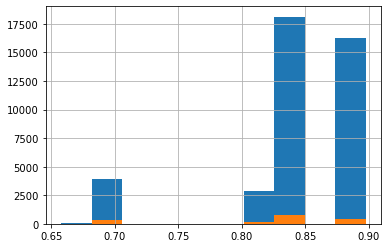

In [146]:
check = 'HAPPY'
check_pos = probs[(probs[check]>0.5) & (probs['detailedMatchClassification'].isin([check]))]
check_neg = probs[(probs[check]>0.5) & (~probs['detailedMatchClassification'].isin([check]))]
check_pos[check].hist()
check_neg[check].hist()

In [152]:
check_neg['HAPPY'].value_counts()

0.830901    789
0.897491    397
0.695356    367
0.804675    149
0.658031      9
Name: HAPPY, dtype: int64

#### Hyper-parameter tuning

In [372]:
#combinations = [i for i in product(['DT','RF','NN'],repeat=3)]

In [1]:
def get_hyperspace(combination):
    
    param_hyperopt = {}
    
    for node, clf in enumerate(combination):
        
        if clf == 'DT':
            hyper = {'DT_criterion_'+str(node)   : hp.choice('DT_criterion_'+str(node) ,['gini','entropy']),
                     'DT_max_depth_'+str(node)   : scope.int(hp.quniform('DT_max_depth_'+str(node), 5, 15, 1))}
        elif clf == 'RF':
            hyper = {'RF_max_depth_'   +str(node) : scope.int(hp.quniform('RF_max_depth_'+str(node), 5, 15, 1)),
                     'RF_n_estimators_'+str(node) : scope.int(hp.quniform('RF_n_estimators_'+str(node), 10, 50, 5))}
        elif clf == 'NN':
            hyper = {'NN_dropout_'+str(node)  : hp.uniform('NN_dropout_'+str(node), 0, 0.5),
                     'NN_nodes_'  +str(node)  : scope.int(hp.quniform('NN_nodes_'+str(node), 5, 50, 5)),
                     'NN_layers_' +str(node)  : scope.int(hp.quniform('NN_layers_'+str(node), 1, 2, 1))}
        elif clf == 'LR':
            hyper = {'LR_penalty_' + str(node) : hp.choice('LR_penalty_' + str(node), ['l1','l2'])}
            
        param_hyperopt = {**param_hyperopt, **hyper}
        
    return param_hyperopt

In [2]:
def clf_hypers(params):

    clf = {}
    
    for ix, node in enumerate(['ORDERS','KNOWN','UNHAPPY']):

        node_hypers = [x for x in list(params.keys()) if x[-1] == str(ix)]

        if combination[ix] == 'DT':
            clf[node] = DecisionTreeClassifier(random_state=0, class_weight='balanced', max_depth = params[node_hypers[1]], criterion = params[node_hypers[0]])
        elif combination[ix] == 'RF':
            clf[node] = RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = params[node_hypers[0]], n_estimators = params[node_hypers[1]])
        elif combination[ix] == 'NN':
            if ix == 2:
                output = 3
            else:
                output = 1
            clf[node] = KerasClassifier(functions.neuralNetwork, output = output, nodes = params[node_hypers[1]], layers = params[node_hypers[2]], droprate = params[node_hypers[0]], epochs = 15, verbose = 0)
        elif combination[ix] == 'LR':
            clf[node] = LogisticRegression(penalty = params[node_hypers[0]], class_weight = 'balanced', solver = 'liblinear')
            
    return clf

In [3]:
def objective_function(params):
    
    HC = HierarchicalClassifier(Tree)
    HC.fit_classifiers(clf_hypers(params))
    
    HC = HC.fit(X_train,y_train)
    pred = HC.predict(X_val)
    
    score = f1_score_ancestors(Tree, y_val['detailedMatchClassification'], pred, beta=1)
    accuracy = metrics.accuracy_score(y_val, pred)
    #cross validation score to be implemented
    
    return {'loss': -score, 'status': STATUS_OK, 'accuracy': accuracy}

In [4]:
def hyperopt(param_space, X_train, y_train, X_val, y_val, num_eval):

    trials = Trials()

    best_param = fmin(objective_function, 
                      param_space, 
                      algo = tpe.suggest, 
                      max_evals = num_eval, 
                      trials = trials,
                      rstate = np.random.RandomState(1))
    
    loss = [x['result']['loss'] for x in trials.trials]
    index_min_loss = loss.index(min(loss))
    accuracy_scores = [x['result']['accuracy'] for x in trials.trials]
    
    f1 = min(loss)*-1
    accuracy = accuracy_scores[index_min_loss]
    
    return best_param, f1, accuracy

In [425]:
combination = ('NN', 'NN', 'NN')
best_param, trials = hyperopt(get_hyperspace(combination), X_train, y_train, X_test, y_test, 10)

 90%|█████████ | 9/10 [2:00:17<13:21, 801.93s/trial, best loss: -0.7816644024189379]  


KeyboardInterrupt: 

#### CAT-HCOT

In [199]:
CLASSIFIERS = {0: {'ORDERS'  : RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = 10, n_estimators = 45),
                   'KNOWN'   : RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = 9 , n_estimators = 30),
                   'UNHAPPY' : RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = 12, n_estimators = 30)},
               1: {'ORDERS'  : RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = 12, n_estimators = 30),
                   'KNOWN'   : RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = 14, n_estimators = 30),
                   'UNHAPPY' : LogisticRegression(random_state=0, class_weight='balanced', solver = 'liblinear', penalty = 'l2')},
               2: {'ORDERS'  : RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = 12, n_estimators = 30),
                   'KNOWN'   : RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = 14, n_estimators = 30),
                   'UNHAPPY' : LogisticRegression(random_state=0, class_weight='balanced', solver = 'liblinear', penalty = 'l2')},
               3: {'ORDERS'  : LogisticRegression(random_state=0, class_weight='balanced', solver = 'liblinear', penalty = 'l2'),
                   'KNOWN'   : RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = 12, n_estimators = 30),
                   'UNHAPPY' : RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = 14, n_estimators = 30)},
               4: {'ORDERS'  : LogisticRegression(random_state=0, class_weight='balanced', solver = 'liblinear', penalty = 'l2'),
                   'KNOWN'   : RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = 12, n_estimators = 30),
                   'UNHAPPY' : RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = 14, n_estimators = 30)},
               5: {'ORDERS'  : LogisticRegression(random_state=0, class_weight='balanced', solver = 'liblinear', penalty = 'l2'),
                   'KNOWN'   : RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = 12, n_estimators = 30),
                   'UNHAPPY' : RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = 14, n_estimators = 30)},
               6: {'ORDERS'  : LogisticRegression(random_state=0, class_weight='balanced', solver = 'liblinear', penalty = 'l1'),
                   'KNOWN'   : RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = 10, n_estimators = 45),
                   'UNHAPPY' : RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = 14, n_estimators = 45)},
               7: {'ORDERS'  : LogisticRegression(random_state=0, class_weight='balanced', solver = 'liblinear', penalty = 'l1'),
                   'KNOWN'   : RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = 10, n_estimators = 45),
                   'UNHAPPY' : RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = 14, n_estimators = 45)},
               8: {'ORDERS'  : LogisticRegression(random_state=0, class_weight='balanced', solver = 'liblinear', penalty = 'l1'),
                   'KNOWN'   : RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = 10, n_estimators = 45),
                   'UNHAPPY' : RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = 14, n_estimators = 45)},
               9: {'ORDERS'  : LogisticRegression(random_state=0, class_weight='balanced', solver = 'liblinear', penalty = 'l1'),
                   'KNOWN'   : RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = 10, n_estimators = 45),
                   'UNHAPPY' : RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = 14, n_estimators = 45)},
              10: {'ORDERS'  : LogisticRegression(random_state=0, class_weight='balanced', solver = 'liblinear', penalty = 'l1'),
                   'KNOWN'   : RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = 10, n_estimators = 45),
                   'UNHAPPY' : RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = 14, n_estimators = 45)}}

In [203]:
def dynamicHierarchicalClassifier(START, END, threshold = None, threshold_type = None):  
  
    Tree = ClassHierarchy('ORDERS')
    Tree.add_node(['UNKNOWN','KNOWN'], 'ORDERS')
    Tree.add_node(['HAPPY','UNHAPPY'], 'KNOWN')
    Tree.add_node(['MILDLY UNHAPPY','MEDIUM UNHAPPY','HEAVILY UNHAPPY'], 'UNHAPPY')
    
#     hypers = pd.DataFrame({'1_penalty'     : ['l1','l1','l2','l2','l2','l2','l1','l1','l1','l1','l1'],
#                            '2_max_depth'   : [ 9,10,12,12,12,12,10,10,10,10,10], 
#                            '2_n_estimators': [35,45,30,30,30,30,45,45,45,45,45],
#                            '3_max_depth'   : [14,14,14,14,14,14,14,14,14,14,14], 
#                            '3_n_estimators': [20,45,30,30,30,30,45,45,45,45,45]})
    
#     # Lourens
    OPTION = 2
    certainties = [0.7, 0.6, 0.8]
    
#     # Thomas
#     OPTION = 2
#     certainties = [0.9, 0.4, 0.5]
    
#     # Jim
#     OPTION = 2
#     certainties = [0.6, 0.8]
    
    # Mathilde
#     OPTION = 2
#     certainties = [0, 0.1, 0.2]
    
    statistics, previous_pred_block, feature_importances = None, None, None
    
    for CERTAINTY in certainties:  
        for DAYS in range(START, END+1):

            X, y = functions.dataX(df, DATE, X_col, Y_col, historic_variable, DAYS)

            X_train_preburn = X.iloc[:int(0.8*len(X))]
            y_train_preburn = y.iloc[:int(0.8*len(y))]

            X_train = X_train_preburn.iloc[int(0.1*len(X_train_preburn)):]
            y_train = y_train_preburn.iloc[int(0.1*len(y_train_preburn)):]

            X_test = X.iloc[int(0.8*len(X)):]
            y_test = y.iloc[int(0.8*len(y)):]

            N_test = len(y_test)

            HC = HierarchicalClassifier(Tree)
            HC.fit_classifiers(CLASSIFIERS[DAYS])
#             HC.fit_classifiers({'ORDERS'  : LogisticRegression(random_state=0, class_weight='balanced', solver = 'liblinear', penalty = hypers.loc[DAYS, '1_penalty']),
#                                 'KNOWN'   : RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = hypers.loc[DAYS, '2_max_depth'], n_estimators = hypers.loc[DAYS, '2_n_estimators']),
#                                 'UNHAPPY' : RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = hypers.loc[DAYS, '3_max_depth'], n_estimators = hypers.loc[DAYS, '3_n_estimators'])})

            HC = HC.fit(X_train,y_train)

            y_train_hat = HC.get_probabilities(X_train, y_train)
            probs = pd.concat([y_train, y_train_hat], axis=1)

            THRESHOLDS = {}
            for node in range(1,8):
                name, threshold = opt_threshold(probs, node, DAYS, CERTAINTY, OPTION)
                THRESHOLDS[name] = threshold

            if DAYS == START: #create dataframe to save predictions
                y_hat = pd.DataFrame([Tree.root] * len(X_test),
                                        columns=[DAYS],
                                        index=X_test.index)
                index_no_leaf = X_test.index
            else:
                y_hat[DAYS] = y_hat[DAYS - 1]

            if DAYS < END:
                pred = HC.predict_proba2(X_test.loc[index_no_leaf], THRESHOLDS = THRESHOLDS)

                check_no_leaf = ~pred.isin(Tree._get_leaf_nodes())
                index_no_leaf = check_no_leaf[check_no_leaf].index
                check_leaf    = pred.isin(Tree._get_leaf_nodes())      #from current non_leaf predictions which are now leaf
                index_leaf    = check_leaf[check_leaf].index
                y_hat_stage   = pd.DataFrame(pred, index = index_leaf)
            else:
                pred        = HC.predict(X_test.loc[index_no_leaf]) #last day you want a label for each order
                y_hat_stage = pd.DataFrame(pred, index = index_no_leaf)
                index_leaf  = index_no_leaf

            y_hat = y_hat.assign(stage_col = y_hat_stage)
            y_hat.stage_col = y_hat.stage_col.fillna(y_hat[DAYS]) #fill previously predicted labels
            y_hat = y_hat.drop(DAYS, axis=1)
            y_hat = y_hat.rename(columns={'stage_col': DAYS})

            current_pred = y_hat.iloc[:, y_hat.shape[1] - 1]

            statistics, feature_importances, previous_pred_block = get_performance(DAYS, END, pred, current_pred, index_leaf, index_no_leaf, 
                                                                                   previous_pred_block, THRESHOLDS, OPTION, CERTAINTY, y_test, Tree, HC, feature_importances, statistics)
            
            file_name = 'statistics_optimal_'+str(OPTION)+'_'+str(CERTAINTY)+'.json'
            path_name = '/Users/LV/Desktop/' + file_name
            with open(path_name, 'w') as f:
                json.dump(statistics, f, cls = NumpyEncoder)

            print('DAYS: ',DAYS)
     
    final_pred = y_hat.iloc[:, y_hat.shape[1] - 1]
        
    return final_pred, statistics, feature_importances

In [201]:
pred, statistics, feature_importances = dynamicHierarchicalClassifier(0,10)

DAYS:  0
DAYS:  1
DAYS:  2
DAYS:  3
DAYS:  4


In [202]:
statistics

{'%classified': {0: 0.4005, 1: 0.6424, 2: 0.7623, 3: 0.83505, 4: 1.0},
 'N_classified': {0: 8010, 1: 4838, 2: 2398, 3: 1455, 4: 3299},
 'N_predicted': {0: 20000, 1: 11990, 2: 7152, 3: 4754, 4: 3299},
 'leaf_accuracy': {0: 0.8917602996254682,
  1: 0.9047126911947085,
  2: 0.9478732276897415,
  3: 0.9429553264604811,
  4: 0.8390421339799939},
 'total_leaf_accuracy': {0: 0.8917602996254682,
  1: 0.8966376089663761,
  2: 0.9046963137872229,
  3: 0.9080294593138135,
  4: 0.89665},
 'leaf_precision': {0: 0.9319505611592556,
  1: 0.936728960547209,
  2: 0.9657453342782897,
  3: 0.9652103559870551,
  4: 0.8567921440261865},
 'total_leaf_precision': {0: 0.9319505611592556,
  1: 0.9337076128452728,
  2: 0.9388255717412635,
  3: 0.9410769761822575,
  4: 0.9289089727686219},
 'leaf_recall': {0: 0.8799463447350772,
  1: 0.8881297046902142,
  2: 0.9412848261570343,
  3: 0.93203125,
  4: 0.787514103046258},
 'total_leaf_recall': {0: 0.8799463447350772,
  1: 0.882947547249947,
  2: 0.8920324153757889,

In [313]:
with open('/Users/LV/Desktop/Statistics/Final/statistics_2_0.7.json') as f:
    statistics = json.load(f)

results = pd.DataFrame.from_dict(statistics)

for ix, node in enumerate(['ORDERS','KNOWN','UNHAPPY']):
    col_name1 = 'block_'+node
    results[col_name1] = results['%blocking'].apply(lambda x: x[node])
    col_name2 = 'Nblock_'+node
    results[col_name2] = results['%Tblocking'].apply(lambda x: x[node])
    col_name3 = 'blockCum_'+node
    results[col_name3] = results[col_name2] / results['N_predicted'].iloc[0]
for ix, node in enumerate(['UNKNOWN','KNOWN','HAPPY','UNHAPPY','MILDLY UNHAPPY','MEDIUM UNHAPPY','HEAVILY UNHAPPY']):
    col_name = 'threshold_'+node
    results[col_name] = results['thresholds'].apply(lambda x: x[node])

results_plot = results.drop(['%blocking','%Tblocking','thresholds'], axis = 1)
results = results_plot.transpose()

# with pd.ExcelWriter('/Users/LV/Desktop/OUTPUT.xlsx', mode = 'a', engine = 'openpyxl') as writer: 
#     results.to_excel(writer, sheet_name = 'LRRFRF-O2C70-2') #CHANGE SHEET NAME!

#feature_importances.to_excel('/Users/LV/Desktop/OUTPUT_featureimportance.xlsx')
#pred.to_csv('/Users/LV/Desktop/OUTPUT_pred.xlsx')

results

,0,1,2,3,4,5,6,7,8,9,10
%classified,0.389673,0.548674,0.649158,0.708673,0.753399,0.776252,0.787030,0.792993,0.798207,0.802316,1.000000
N_classified,371978.000000,151781.000000,95921.000000,56812.000000,42695.000000,21815.000000,10289.000000,5692.000000,4977.000000,3923.000000,188707.000000
N_predicted,954590.000000,582612.000000,430831.000000,334910.000000,278098.000000,235403.000000,213588.000000,203299.000000,197607.000000,192630.000000,188707.000000
leaf_accuracy,0.907040,0.941159,0.952961,0.953197,0.957021,0.960761,0.955584,0.956606,0.960217,0.970941,0.967187
total_leaf_accuracy,0.907040,0.916927,0.922505,0.925083,0.926979,0.927973,0.928351,0.928564,0.928771,0.928987,0.936538
leaf_precision,0.939998,0.965407,0.972158,0.973109,0.974015,0.977949,0.978356,0.981217,0.981719,0.985651,0.980724
total_leaf_precision,0.939998,0.947748,0.951807,0.953711,0.954891,0.955604,0.955980,0.956235,0.956446,0.956622,0.961357
leaf_recall,0.879901,0.926713,0.945047,0.946235,0.945776,0.960042,0.967589,0.975874,0.974789,0.979855,0.960087
total_leaf_recall,0.879901,0.893930,0.902219,0.906063,0.908323,0.909874,0.910794,0.911424,0.911927,0.912319,0.921509
label_precision,0.950019,0.968139,0.975530,0.980693,0.981588,0.993608,0.996568,0.998254,0.998562,0.999115,0.980724


In [315]:
# LATEX COORDINATES GENERATOR
col = results_plot['leaf_recall']
for i in range(11):
    print((i,round(col[i]*100,2)), end = '')

(0, 87.99)(1, 92.67)(2, 94.5)(3, 94.62)(4, 94.58)(5, 96.0)(6, 96.76)(7, 97.59)(8, 97.48)(9, 97.99)(10, 96.01)

In [308]:
# LATEX COORDINATES GENERATOR
col = results_plot['leaf_accuracy']
for i in range(11):
    print((i,round(col[i]*100,2)), end = '')

(0, 91.61)(1, 96.55)(2, 97.07)(3, 96.82)(4, 96.65)(5, 97.3)(6, 98.05)(7, 97.42)(8, 98.35)(9, 98.32)(10, 97.63)

In [318]:
precision_col = results_plot['leaf_precision']
recall_col = results_plot['leaf_recall']
beta = 1
for i in range(11):
    f1 = ((beta ** 2 + 1) * precision_col[i] * recall_col[i]) / ((beta ** 2 * precision_col[i]) + recall_col[i])
    print((i,round(f1*100,2)), end = '')

(0, 90.9)(1, 94.57)(2, 95.84)(3, 95.95)(4, 95.97)(5, 96.89)(6, 97.29)(7, 97.85)(8, 97.82)(9, 98.27)(10, 97.03)

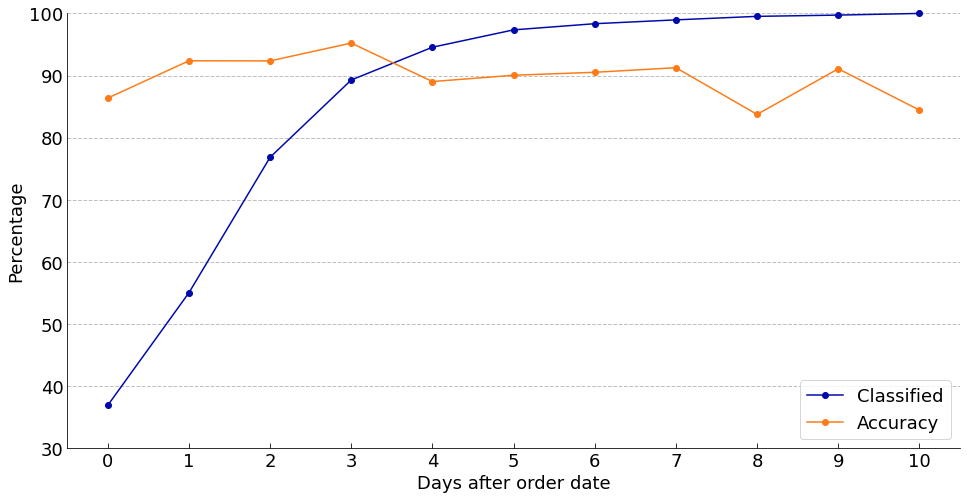

In [1425]:
### Plot parameters
plt.rcParams.update({'font.size': 18})

# Colors
bol_darkblue  = '#0009AA' #dark blue
bol_lightblue = '#D2EFFF' #light blue
bol_happy     = '#26DD8C' #green
bol_unknown   = '#BFBFBF' #grey
bol_mildly    = '#FFBC89' #light orange
bol_medium    = '#FF7B18' #medium orange
bol_heavy     = '#D23C00' #red
bol_order     = '#78CEFF' #light blue
bol_lines     = '#B7B18B' #taupe

### Plotten
#plt.plot(data, color = , marker = , linewidth = , label = , clip_on = False)
plt.figure(figsize = (16,8))

plt.plot(results_plot['%classified']*100  , color = bol_darkblue, marker = 'o', label = 'Classified', clip_on = False)
plt.plot(results_plot['leaf_accuracy']*100, color = bol_medium  , marker = 'o', label = 'Accuracy')

### Titel
plt.title('', fontweight = 'bold')

### Assen
plt.ylabel('Percentage', fontweight = 'normal')
plt.ylim(30,100)

plt.xlabel('Days after order date', fontweight = 'normal')
plt.xticks(range(11))
#plt.xlim(-0.1, 30.1)

### Legend
plt.legend(loc = 'best')

### Grafiek Lay-out
plt.grid(color='#C0C0C0', linestyle='--', linewidth=1, axis='y')
plt.tick_params(axis='x', direction='in', length=5, colors='black')
plt.tick_params(axis='y', length=0)
sns.despine(left=False, bottom=False, right=True)

#plt.savefig('plot.png',dpi = 300)
plt.show()

#### CAT-HCOT (Flavius Approach)

In [128]:
def dynamicFullHierarchicalClassifier(START, END, threshold = None, threshold_type = None):  
  
    Tree = ClassHierarchy('ORDERS')
    Tree.add_node(['UNKNOWN','KNOWN'], 'ORDERS')
    Tree.add_node(['HAPPY','UNHAPPY'], 'KNOWN')
    Tree.add_node(['MILDLY UNHAPPY','MEDIUM UNHAPPY','HEAVILY UNHAPPY'], 'UNHAPPY')
    
    hypers = pd.DataFrame({'1_penalty'     : ['l1','l1','l2','l2','l2','l2','l1','l1','l1','l1','l1'],
                           '2_max_depth'   : [ 9,10,12,12,12,12,10,10,10,10,10], 
                           '2_n_estimators': [35,45,30,30,30,30,45,45,45,45,45],
                           '3_max_depth'   : [14,14,14,14,14,14,14,14,14,14,14], 
                           '3_n_estimators': [20,45,30,30,30,30,45,45,45,45,45]})
    
#     # Lourens
    OPTION = 2
    certainties = [0.6,0.7,0.8]
    
#     # Thomas
#     OPTION = 2
#     certainties = [0.3, 0.4, 0.5]
    
#     # Jim
#     OPTION = 2
#     certainties = [0.9, 1.0]
    
    # Mathilde
#     OPTION = 2
#     certainties = [0, 0.1, 0.2]
    
    statistics, previous_pred_block, feature_importances = None, None, None
    
    for CERTAINTY in certainties:  
        for DAYS in range(START, END+1):

            X, y = functions.dataX(df, DATE, X_col, Y_col, historic_variable, DAYS)

            X_train_preburn = X.iloc[:int(0.8*len(X))]
            y_train_preburn = y.iloc[:int(0.8*len(y))]

            X_train = X_train_preburn.iloc[int(0.1*len(X_train_preburn)):]
            y_train = y_train_preburn.iloc[int(0.1*len(y_train_preburn)):]

            X_test = X.iloc[int(0.8*len(X)):]
            y_test = y.iloc[int(0.8*len(y)):]
            #print('Data pre-processing done')

            N_test = len(y_test)

            HC = HierarchicalClassifier(Tree)
            HC.fit_classifiers({'ORDERS'  : LogisticRegression(random_state=0, class_weight='balanced', solver = 'liblinear', penalty = hypers.loc[DAYS, '1_penalty']),
                                'KNOWN'   : RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = hypers.loc[DAYS, '2_max_depth'], n_estimators = hypers.loc[DAYS, '2_n_estimators']),
                                'UNHAPPY' : RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = hypers.loc[DAYS, '3_max_depth'], n_estimators = hypers.loc[DAYS, '3_n_estimators'])})

            HC = HC.fit(X_train,y_train)

            y_train_hat = HC.get_probabilities(X_train, y_train)
            probs = pd.concat([y_train, y_train_hat], axis=1)

            THRESHOLDS = {}
            for node in range(1,8):
                name, threshold = opt_threshold(probs, node, DAYS, CERTAINTY, OPTION)
                THRESHOLDS[name] = threshold

            if DAYS == START: #create dataframe to save predictions
                y_hat = pd.DataFrame([Tree.root] * len(X_test),
                                        columns=[DAYS],
                                        index=X_test.index)
                index_no_leaf = X_test.index
            else:
                y_hat[DAYS] = y_hat[DAYS - 1]

            if DAYS < END:
                pred = HC.predict_proba2(X_test, THRESHOLDS = THRESHOLDS)  #DIFFERENCE ALL TESTING EACH DAY!

                check_no_leaf = ~pred.isin(Tree._get_leaf_nodes())
                index_no_leaf = check_no_leaf[check_no_leaf].index
                check_leaf    = pred.isin(Tree._get_leaf_nodes())      #from current non_leaf predictions which are now leaf
                index_leaf    = check_leaf[check_leaf].index
                y_hat_stage   = pd.DataFrame(pred, index = index_leaf)
            else:
                pred        = HC.predict(X_test) #last day you want a label for each order
                y_hat_stage = pd.DataFrame(pred, index = X_test.index)
                index_leaf  = X_test.index

            y_hat = y_hat.assign(stage_col = y_hat_stage)
            #y_hat.stage_col = y_hat.stage_col.fillna(y_hat[DAYS]) #fill previously predicted labels
            y_hat = y_hat.drop(DAYS, axis=1)
            y_hat = y_hat.rename(columns={'stage_col': DAYS})
                
            current_pred = y_hat.iloc[:, y_hat.shape[1] - 1]

            statistics, feature_importances, previous_pred_block = get_performance(DAYS, END, pred, current_pred, index_leaf, index_no_leaf, 
                                                                                   previous_pred_block, THRESHOLDS, OPTION, CERTAINTY, y_test, Tree, HC, feature_importances, statistics)
            
            if DAYS == 0:
                previous_leaf = index_leaf
                cumu_leaf = index_leaf
                statistics['leaf_improve'] = {}
                statistics['cum%classified'] = {}
                statistics['cum%classified'][DAYS] = len(index_leaf) / N_test
            else:
                index_intersect = previous_leaf.intersection(index_leaf)
                acc_prev = metrics.accuracy_score(y_test.loc[index_intersect], y_hat[DAYS - 1].loc[index_intersect])
                acc_now = metrics.accuracy_score(y_test.loc[index_intersect], y_hat[DAYS].loc[index_intersect])
                acc_diff = (acc_now - acc_prev)/acc_prev
                statistics['leaf_improve'][DAYS] = acc_diff
                statistics['cum%classified'][DAYS] = len(cumu_leaf.union(index_leaf)) / N_test
                cumu_leaf = cumu_leaf.union(index_leaf)
                previous_leaf = index_leaf
            
            file_name = 'statistics_full_'+str(CERTAINTY)+'.json'
            path_name = '/Users/LV/Desktop/' + file_name
            with open(path_name, 'w') as f:
                json.dump(statistics, f, cls = NumpyEncoder)

            print('DAYS: ',DAYS)
     
    final_pred = y_hat.iloc[:, y_hat.shape[1] - 1]
        
    return y_hat, statistics, feature_importances

In [129]:
y_hat, statistics, feature_importances = dynamicFullHierarchicalClassifier(0,10)

DAYS:  0
DAYS:  1
DAYS:  2
DAYS:  3
DAYS:  4
DAYS:  5
DAYS:  6
DAYS:  7
DAYS:  8
DAYS:  9
DAYS:  10
DAYS:  0
DAYS:  1
DAYS:  2
DAYS:  3
DAYS:  4
DAYS:  5
DAYS:  6
DAYS:  7
DAYS:  8
DAYS:  9
DAYS:  10
DAYS:  0
DAYS:  1
DAYS:  2
DAYS:  3
DAYS:  4
DAYS:  5
DAYS:  6
DAYS:  7
DAYS:  8
DAYS:  9
DAYS:  10


In [127]:
statistics

{'%classified': {0: 0.40549,
  1: 0.48413,
  2: 0.58787,
  3: 0.63512,
  4: 0.67787,
  5: 0.70019,
  6: 1.0},
 'N_classified': {0: 40549,
  1: 48413,
  2: 58787,
  3: 63512,
  4: 67787,
  5: 70019,
  6: 100000},
 'N_predicted': {0: 100000,
  1: 100000,
  2: 100000,
  3: 100000,
  4: 100000,
  5: 100000,
  6: 100000},
 'leaf_accuracy': {0: 0.9026856395965375,
  1: 0.9375167826823374,
  2: 0.9570993587017538,
  3: 0.9662583448797077,
  4: 0.9715284641597947,
  5: 0.9764492494894244,
  6: 0.96602},
 'total_leaf_accuracy': {0: 0.9026856395965375,
  1: 0.9375167826823374,
  2: 0.9570993587017538,
  3: 0.9662583448797077,
  4: 0.9715284641597947,
  5: 0.9764492494894244,
  6: 0.96602},
 'leaf_precision': {0: 0.9372120416896537,
  1: 0.9600792681406884,
  2: 0.9729761485136882,
  3: 0.9800079069851025,
  4: 0.9832536496816915,
  5: 0.9865018158077284,
  6: 0.9801494361868638},
 'total_leaf_precision': {0: 0.9372120416896537,
  1: 0.9600792681406884,
  2: 0.9729761485136882,
  3: 0.98000790698

#### Base Case 2 (Flat) - Flavius Approach

In [145]:
def dynamicFullFlatClassifier(START, END, threshold = None, threshold_type = None):  
    
    hypers = pd.DataFrame({'LR_penalty'     : ['l1','l1','l1','l1','l1','l1','l2','l1','l1','l1','l1'],
                           'RF_max_depth'   : [14,14,14,14,14,14,14,14,14,14,14], 
                           'RF_n_estimators': [45,45,40,45,40,45,40,45,45,45,45]})
    
#     # Lourens
    OPTION = 2
    certainties = [0.7]
    
#     # Thomas
#     OPTION = 2
#     certainties = [0.3, 0.4, 0.5]
    
#     # Jim
#     OPTION = 2
#     certainties = [0.9, 1.0]
    
    # Mathilde
#     OPTION = 2
#     certainties = [0, 0.1, 0.2]

    statistics = {'accuracy'  :{},
                  'classified':{},
                  'thresholds':{},
                  'precision' :{},
                  'recall'    :{},
                  'f1'        :{}}
    for leaf in ['HAPPY','UNKNOWN','MILDLY UNHAPPY','MEDIUM UNHAPPY','HEAVILY UNHAPPY']: 
        statistics['precision_'+leaf] = {}
        statistics['recall_'+leaf]    = {}
        statistics['f1_'+leaf]        = {}
    
    #statistics, previous_pred_block, feature_importances = None, None, None
    
    for CERTAINTY in certainties:  
        for DAYS in range(START, END+1):

            X, y = functions.dataX(df, DATE, X_col, Y_col, historic_variable, DAYS)

            X_train_preburn = X.iloc[:int(0.8*len(X))]
            y_train_preburn = y.iloc[:int(0.8*len(y))]

            X_train = X_train_preburn.iloc[int(0.1*len(X_train_preburn)):]
            y_train = y_train_preburn.iloc[int(0.1*len(y_train_preburn)):]

            X_test = X.iloc[int(0.8*len(X)):]
            y_test = y.iloc[int(0.8*len(y)):]
            #print('Data pre-processing done')
            
            N_test = len(y_test)

            if DAYS < 5:
                clf = LogisticRegression(random_state=0, class_weight='balanced', solver = 'liblinear', penalty = hypers.loc[DAYS, 'LR_penalty'])
            else:
                clf = RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = hypers.loc[DAYS, 'RF_max_depth'], n_estimators = hypers.loc[DAYS, 'RF_n_estimators'])
                
            clf.fit(X_train, y_train)

            y_train_hat = clf.predict_proba(X_train) 
            y_classes = clf.classes_
            y_train_hat = pd.DataFrame(y_train_hat, index = X_train.index, columns = y_classes)
            probs = pd.concat([y_train, y_train_hat], axis=1)
            
            THRESHOLDS = {}
            for node in range(1,6):
                name, threshold = flat_thresholds(probs, node, DAYS, CERTAINTY, steps = 100)
                THRESHOLDS[name] = threshold

            if DAYS == START: #create dataframe to save predictions
                y_hat = pd.DataFrame(['ORDERS'] * len(X_test),
                                        columns=[DAYS],
                                        index=X_test.index)
                index_no_leaf = X_test.index
            else:
                y_hat[DAYS] = y_hat[DAYS - 1]

            if DAYS < END:
                y_proba = clf.predict_proba(X_test)
                y_classes = clf.classes_
            
                max_prob = np.amax(y_proba, axis=1)              #max probability of classes
                max_class = np.argmax(y_proba, axis=1)           #class number with max probability
                max_class_thresholds = np.vectorize(lambda x: THRESHOLDS[y_classes[x]])(max_class)  #get node specific threshold

                accept_index = np.where(max_prob >= max_class_thresholds)[0]
                accept_class = np.take(max_class, accept_index)  #filtered list of orders which are above threshold

                if len(accept_class) > 0: #check if samples reach threshold
                    accept_label = np.vectorize(lambda x: y_classes[x])(accept_class)                             #convert class number into label
                    y_hat_stage = pd.DataFrame(accept_label, index = np.take(X_test.index.values, accept_index))  #set labels to correct position
                else:
                    y_hat_stage = pd.DataFrame(columns = [0], index = X_test.index)
            else:
                pred        = clf.predict(X_test) #last day you want a label for each order
                y_hat_stage = pd.DataFrame(pred, index = X_test.index)
                index_leaf  = X_test.index

            y_hat = y_hat.assign(stage_col = y_hat_stage)
            y_hat.stage_col = y_hat.stage_col.fillna('ORDERS') #fill previously predicted labels
            y_hat = y_hat.drop(DAYS, axis=1)
            y_hat = y_hat.rename(columns={'stage_col': DAYS})
                
            current_pred = y_hat.iloc[:, y_hat.shape[1] - 1]
            
            check_no_leaf = (current_pred == 'ORDERS')    #from current non_leaf predictions which are now leaf
            index_no_leaf = check_no_leaf[check_no_leaf].index
            check_leaf    = (current_pred != 'ORDERS')    #from current non_leaf predictions which are now leaf
            index_leaf    = check_leaf[check_leaf].index

            #statistics, feature_importances, previous_pred_block = get_performance(DAYS, END, pred, current_pred, index_leaf, index_no_leaf, 
            #                                                                       previous_pred_block, THRESHOLDS, OPTION, CERTAINTY, y_test, Tree, HC, feature_importances, statistics)
            
            if DAYS == 0:
                previous_leaf = index_leaf
                cumu_leaf = index_leaf
                statistics['leaf_improve'] = {}
                statistics['cum%classified'] = {}
                statistics['cum%classified'][DAYS] = len(index_leaf) / N_test
            else:
                index_intersect = previous_leaf.intersection(index_leaf)
                acc_prev = metrics.accuracy_score(y_test.loc[index_intersect], y_hat[DAYS - 1].loc[index_intersect])
                acc_now = metrics.accuracy_score(y_test.loc[index_intersect], y_hat[DAYS].loc[index_intersect])
                acc_diff = (acc_now - acc_prev)/acc_prev
                statistics['leaf_improve'][DAYS] = acc_diff
                statistics['cum%classified'][DAYS] = len(cumu_leaf.union(index_leaf)) / N_test
                cumu_leaf = cumu_leaf.union(index_leaf)
                previous_leaf = index_leaf
            
            #print(current_pred)
            #print(index_leaf)
            #print(current_pred.loc[index_leaf])
            statistics['accuracy'][DAYS]   = metrics.accuracy_score(y_test.loc[index_leaf], current_pred.loc[index_leaf])
            statistics['classified'][DAYS] = (current_pred != 'ORDERS').sum() / len(y_test)
            statistics['thresholds'][DAYS] = THRESHOLDS
            
            precision, recall, f1, support = metrics.precision_recall_fscore_support(y_test.loc[index_leaf], current_pred.loc[index_leaf], average = 'weighted', beta = 1)
            
            statistics['precision'][DAYS] = precision
            statistics['recall'][DAYS]    = recall
            statistics['f1'][DAYS]        = f1
            
            for leaf in ['HAPPY','UNKNOWN','MILDLY UNHAPPY','MEDIUM UNHAPPY','HEAVILY UNHAPPY']:
                leaf_ix = current_pred.loc[current_pred == leaf].index
                precision, recall, f1, support = metrics.precision_recall_fscore_support(y_test.loc[leaf_ix], current_pred.loc[leaf_ix])
                statistics['precision_'+leaf][DAYS] = precision
                statistics['recall_'+leaf][DAYS]    = recall
                statistics['f1_'+leaf][DAYS]        = f1
            
            file_name = 'statistics_flat_full_'+str(CERTAINTY)+'.json'
            path_name = '/Users/LV/Desktop/' + file_name
            with open(path_name, 'w') as f:
                json.dump(statistics, f, cls = NumpyEncoder)

            print('DAYS: ',DAYS)
     
    final_pred = y_hat.iloc[:, y_hat.shape[1] - 1]
        
    return y_hat, statistics

In [146]:
y_hat, statistics = dynamicFullFlatClassifier(0,10)

DAYS:  0
DAYS:  1
DAYS:  2
DAYS:  3
DAYS:  4
DAYS:  5
DAYS:  6
DAYS:  7
DAYS:  8
DAYS:  9
DAYS:  10


In [147]:
statistics

{'accuracy': {0: 0.8888601683410263,
  1: 0.9284199575881247,
  2: 0.9501834623321196,
  3: 0.9604429931934283,
  4: 0.9639776627718792,
  5: 0.9759037741350388,
  6: 0.9804518500589962,
  7: 0.9837115699063842,
  8: 0.9859768635143331,
  9: 0.9876666059340443,
  10: 0.9819880786515677},
 'classified': {0: 0.48227511287568486,
  1: 0.5236384206832253,
  2: 0.5949821389287547,
  3: 0.5922291245456165,
  4: 0.5890382258351753,
  5: 0.5532993222221059,
  6: 0.5540053845106276,
  7: 0.5830042217077489,
  8: 0.6200347793293456,
  9: 0.5979614284666716,
  10: 1.0},
 'thresholds': {0: {'UNKNOWN': 0.6203176205097817,
   'HAPPY': 0.6712599189728522,
   'MILDLY UNHAPPY': 0.3675430552553664,
   'MEDIUM UNHAPPY': 0.3692428155885042,
   'HEAVILY UNHAPPY': 0.4957362793796634},
  1: {'UNKNOWN': 0.6447920086645453,
   'HAPPY': 0.6608566930711927,
   'MILDLY UNHAPPY': 0.41484603020429106,
   'MEDIUM UNHAPPY': 0.35960811635192175,
   'HEAVILY UNHAPPY': 0.6894599643876529},
  2: {'UNKNOWN': 0.68962342783

#### Bugfixing

In [247]:
X, y = functions.dataX(df_, DATE, X_col, Y_col, historic_variable, 10)

X_train_preburn = X.iloc[:int(0.8*len(X))]
y_train_preburn = y.iloc[:int(0.8*len(y))]

X_train = X_train_preburn.iloc[int(0.1*len(X_train_preburn)):]
y_train = y_train_preburn.iloc[int(0.1*len(y_train_preburn)):]

X_test = X.iloc[int(0.8*len(X)):]
y_test = y.iloc[int(0.8*len(y)):]

In [248]:
Tree = ClassHierarchy('ORDERS')
Tree.add_node(['UNKNOWN','KNOWN'], 'ORDERS')
Tree.add_node(['HAPPY','UNHAPPY'], 'KNOWN')
Tree.add_node(['MILDLY UNHAPPY','MEDIUM UNHAPPY','HEAVILY UNHAPPY'], 'UNHAPPY')

hypers = pd.DataFrame({'1_penalty'     : ['l1','l1','l2','l2','l2','l2','l1','l1','l1','l1','l1'],
                       '2_max_depth'   : [ 9,10,12,12,12,12,10,10,10,10,10], 
                       '2_n_estimators': [35,45,30,30,30,30,45,45,45,45,45],
                       '3_max_depth'   : [14,14,14,14,14,14,14,14,14,14,14], 
                       '3_n_estimators': [20,45,30,30,30,30,45,45,45,45,45]})

OPTION = 2
CERTAINTY = 0.7
DAYS = 10

HC = HierarchicalClassifier(Tree)
HC.fit_classifiers({'ORDERS'  : LogisticRegression(random_state=0, class_weight='balanced', solver = 'liblinear', penalty = hypers.loc[DAYS, '1_penalty']),
                    'KNOWN'   : RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = hypers.loc[DAYS, '2_max_depth'], n_estimators = hypers.loc[DAYS, '2_n_estimators']),
                    'UNHAPPY' : RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = hypers.loc[DAYS, '3_max_depth'], n_estimators = hypers.loc[DAYS, '3_n_estimators'])})

HC = HC.fit(X_train,y_train)

In [253]:
y_train_hat = HC.get_probabilities(X_train, y_train)
probs = pd.concat([y_train, y_train_hat], axis=1)

THRESHOLDS = {}
for node in range(1,8):
    name, threshold = opt_threshold(probs, node, DAYS, CERTAINTY, OPTION)
    THRESHOLDS[name] = threshold

lowerbound: 0.9933733291347455
lowerbound: 0.8421211147061107
lowerbound: 0.6043991631489433
lowerbound: 0.6178093355709303
lowerbound: 0.616404957523803
lowerbound: 0.5189103377173029


#### Base Case 1 (Static)

In [217]:
def staticHierarchicalClassifier(START, END, threshold = None, threshold_type = None):
    
    Tree = ClassHierarchy('ORDERS')
    Tree.add_node(['UNKNOWN','KNOWN'], 'ORDERS')
    Tree.add_node(['HAPPY','UNHAPPY'], 'KNOWN')
    Tree.add_node(['MILDLY UNHAPPY','MEDIUM UNHAPPY','HEAVILY UNHAPPY'], 'UNHAPPY')
    
    hypers = pd.DataFrame({'1_penalty'     : ['l1','l1','l2','l2','l2','l2','l1','l1','l1','l1','l1'],
                           '2_max_depth'   : [ 9,10,12,12,12,12,10,10,10,10,10], 
                           '2_n_estimators': [35,45,30,30,30,30,45,45,45,45,45],
                           '3_max_depth'   : [14,14,14,14,14,14,14,14,14,14,14], 
                           '3_n_estimators': [20,45,30,30,30,30,45,45,45,45,45]})
    
    statistics = {'accuracy':{},
                  'precision':{},
                  'recall':{},
                  'f1':{}}
    for leaf in Tree._get_leaf_nodes(): 
        statistics['precision_'+leaf] = {}
        statistics['recall_'+leaf]    = {}
        statistics['f1_'+leaf]        = {}
    
    for DAYS in range(START, END+1):

        X, y = functions.dataX(df, DATE, X_col, Y_col, historic_variable, DAYS)

        X_train_preburn = X.iloc[:int(0.8*len(X))]
        y_train_preburn = y.iloc[:int(0.8*len(y))]

        X_train = X_train_preburn.iloc[int(0.1*len(X_train_preburn)):]
        y_train = y_train_preburn.iloc[int(0.1*len(y_train_preburn)):]

        X_test = X.iloc[int(0.8*len(X)):]
        y_test = y.iloc[int(0.8*len(y)):]

        HC = HierarchicalClassifier(Tree)
        HC.fit_classifiers({'ORDERS'  : LogisticRegression(random_state=0, class_weight='balanced', solver = 'liblinear', penalty = hypers.loc[DAYS, '1_penalty']),
                            'KNOWN'   : RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = hypers.loc[DAYS, '2_max_depth'], n_estimators = hypers.loc[DAYS, '2_n_estimators']),
                            'UNHAPPY' : RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = hypers.loc[DAYS, '3_max_depth'], n_estimators = hypers.loc[DAYS, '3_n_estimators'])})

        HC = HC.fit(X_train,y_train)
        pred = HC.predict(X_test)
        
        y_test = y_test['detailedMatchClassification']
        
        statistics['accuracy'][DAYS] = metrics.accuracy_score(y_test, pred)
        statistics['precision'][DAYS] = precision_score_ancestors(Tree, y_test, pred)
        statistics['recall'][DAYS] = recall_score_ancestors(Tree, y_test, pred)
        statistics['f1'][DAYS] = f1_score_ancestors(Tree, y_test, pred, beta = 1)
        
        for leaf in Tree._get_leaf_nodes():
            leaf_ix = pred.loc[pred == leaf].index
            statistics['precision_'+leaf][DAYS] = precision_score_ancestors(Tree, y_test.loc[leaf_ix], pred.loc[leaf_ix])
            statistics['recall_'+leaf][DAYS]    = recall_score_ancestors(Tree, y_test.loc[leaf_ix], pred.loc[leaf_ix])
            statistics['f1_'+leaf][DAYS]        = f1_score_ancestors(Tree, y_test.loc[leaf_ix], pred.loc[leaf_ix], beta = 1)
            
        print('DAY ',DAYS)
            
    return statistics

In [218]:
stats = staticHierarchicalClassifier(6, 8)

DAY  6
DAY  7
DAY  8


In [220]:
stats_35 = {'accuracy': {3: 0.9103269466472517,
  4: 0.9357986151122472,
  5: 0.9545082181879131},
 'precision': {3: 0.9288946029914686,
  4: 0.955768017729528,
  5: 0.9721027885169434},
 'recall': {3: 0.9043605128064413,
  4: 0.9235396698716583,
  5: 0.9425898021366741},
 'f1': {3: 0.9164633904636592, 4: 0.939377500971662, 5: 0.9571188393975034},
 'precision_UNKNOWN': {3: 0.9008640954075591,
  4: 0.9092636776450946,
  5: 0.9305363496410377},
 'recall_UNKNOWN': {3: 0.764873959770202,
  4: 0.7819209327189879,
  5: 0.8251461300905099},
 'f1_UNKNOWN': {3: 0.8273179396092362,
  4: 0.8407979809592633,
  5: 0.8746780544649013},
 'precision_HAPPY': {3: 0.9804231956077426,
  4: 0.9857077197261045,
  5: 0.9882203444853589},
 'recall_HAPPY': {3: 0.9643788328443436,
  4: 0.9725926350978643,
  5: 0.9769648553804453},
 'f1_HAPPY': {3: 0.9723348322772593,
  4: 0.9791062603886375,
  5: 0.9825603673384882},
 'precision_MILDLY UNHAPPY': {3: 0.7620270901447922,
  4: 0.8904332967167093,
  5: 0.9656225092861332},
 'recall_MILDLY UNHAPPY': {3: 0.8664849755415793,
  4: 0.938710490964584,
  5: 0.9766228630528685},
 'f1_MILDLY UNHAPPY': {3: 0.810905904203835,
  4: 0.9139347958989367,
  5: 0.9710915346515937},
 'precision_MEDIUM UNHAPPY': {3: 0.7930544350966156,
  4: 0.8809708737864078,
  5: 0.9170888213441405},
 'recall_MEDIUM UNHAPPY': {3: 0.8657217143336409,
  4: 0.9105565962001606,
  5: 0.9312946556158902},
 'f1_MEDIUM UNHAPPY': {3: 0.8277963790925676,
  4: 0.8955194420685572,
  5: 0.9241371486911886},
 'precision_HEAVILY UNHAPPY': {3: 0.9051029543419875,
  4: 0.9224098880476282,
  5: 0.9510307643514113},
 'recall_HEAVILY UNHAPPY': {3: 0.9285878300803674,
  4: 0.9282365199270644,
  5: 0.9525412960609911},
 'f1_HEAVILY UNHAPPY': {3: 0.9166950017001021,
  4: 0.9253140316141387,
  5: 0.9517854308839867}}

In [221]:
stats_68 = stats

In [222]:
stats_910 = {'accuracy': {9: 0.9798615112247143, 10: 0.9823044448401932},
 'precision': {9: 0.9885632839696289, 10: 0.9900067286218827},
 'recall': {9: 0.9766856272794625, 10: 0.9801185043164926},
 'f1': {9: 0.9825885622759623, 10: 0.9850378015543084},
 'precision_UNKNOWN': {9: 0.9777753922221766, 10: 0.9823523627978673},
 'recall_UNKNOWN': {9: 0.9371296806250718, 10: 0.9493739175747544},
 'f1_UNKNOWN': {9: 0.9570211641601474, 10: 0.9655816360569773},
 'precision_HAPPY': {9: 0.9935202273356639, 10: 0.9942228581316295},
 'recall_HAPPY': {9: 0.987123888943773, 10: 0.9885120835861538},
 'f1_HAPPY': {9: 0.9903117298973837, 10: 0.9913592466264884},
 'precision_MILDLY UNHAPPY': {9: 0.9883924660534384, 10: 0.9895021782345726},
 'recall_MILDLY UNHAPPY': {9: 0.9887491300873779, 10: 0.989631935837292},
 'f1_MILDLY UNHAPPY': {9: 0.9885707659004226, 10: 0.9895670527822955},
 'precision_MEDIUM UNHAPPY': {9: 0.9548252477829943, 10: 0.9572140512945181},
 'recall_MEDIUM UNHAPPY': {9: 0.9557026795597419, 10: 0.9576602687529135},
 'f1_MEDIUM UNHAPPY': {9: 0.9552637621860844, 10: 0.9574371080333532},
 'precision_HEAVILY UNHAPPY': {9: 0.9745694511508128, 10: 0.9707193515704154},
 'recall_HEAVILY UNHAPPY': {9: 0.9746740355207383, 10: 0.9707193515704154},
 'f1_HEAVILY UNHAPPY': {9: 0.9746217405300999, 10: 0.9707193515704154}}

In [226]:
stats_02 = {'accuracy': {0: 0.8173152871913596,
  1: 0.8359327040928566,
  2: 0.8777391340785049},
 'precision': {0: 0.8499370720856377,
  1: 0.8613588547588565,
  2: 0.8968386013389915},
 'recall': {0: 0.818899973085777,
  1: 0.8425541305742654,
  2: 0.8795976761524221},
 'f1': {0: 0.83412990797318, 1: 0.8518527263197162, 2: 0.8881344741907056},
 'precision_UNKNOWN': {0: 0.8795418054008444,
  1: 0.8811734839494675,
  2: 0.8920568864334167},
 'recall_UNKNOWN': {0: 0.724613037933535,
  1: 0.7308493513871792,
  2: 0.7484755065131178},
 'f1_UNKNOWN': {0: 0.794595935983723,
  1: 0.7990024149621412,
  2: 0.8139829884279844},
 'precision_HAPPY': {0: 0.9186210067894722,
  1: 0.9430937323600042,
  2: 0.9702039555846461},
 'recall_HAPPY': {0: 0.8767846539126842,
  1: 0.9107136917806448,
  2: 0.9492838933246677},
 'f1_HAPPY': {0: 0.8972153972153972,
  1: 0.9266209245989108,
  2: 0.9596299229502426},
 'precision_MILDLY UNHAPPY': {0: 0.45632014014342803,
  1: 0.5425416358287215,
  2: 0.6535517490712345},
 'recall_MILDLY UNHAPPY': {0: 0.6293631318660576,
  1: 0.7086605841697969,
  2: 0.7946332675051103},
 'f1_MILDLY UNHAPPY': {0: 0.5290512987322089,
  1: 0.6145735140771638,
  2: 0.7172204599601684},
 'precision_MEDIUM UNHAPPY': {0: 0.364867042707494,
  1: 0.5477867793824116,
  2: 0.6562103124206249},
 'recall_MEDIUM UNHAPPY': {0: 0.55404192837915,
  1: 0.7096357137424899,
  2: 0.7783189395460935},
 'f1_MEDIUM UNHAPPY': {0: 0.4399818617607048,
  1: 0.6182950667594341,
  2: 0.7120676190913684},
 'precision_HEAVILY UNHAPPY': {0: 0.37303177784139707,
  1: 0.85002849002849,
  2: 0.9003090507726269},
 'recall_HEAVILY UNHAPPY': {0: 0.6259407526020817,
  1: 0.9218885181065382,
  2: 0.9315669255367748},
 'f1_HEAVILY UNHAPPY': {0: 0.4674718966754365,
  1: 0.8845013636902644,
  2: 0.9156713066906151}}

In [227]:
df_02 = pd.DataFrame.from_dict(stats_02)
df_35 = pd.DataFrame.from_dict(stats_35)
df_68 = pd.DataFrame.from_dict(stats_68)
df_910 = pd.DataFrame.from_dict(stats_910)

In [229]:
df_all = pd.concat([df_02,df_35,df_68,df_910])

In [230]:
col = df_all['accuracy']
for i in range(11):
    print((i,round(col[i]*100,2)), end = '')

(0, 81.73)(1, 83.59)(2, 87.77)(3, 91.03)(4, 93.58)(5, 95.45)(6, 96.54)(7, 97.22)(8, 97.66)(9, 97.99)(10, 98.23)

#### Base Case 2 (Flat)

In [193]:
def dynamicFlatClassifier(START, END):  

    hypers = pd.DataFrame({'LR_penalty'     : ['l1','l1','l1','l1','l1','l1','l2','l1','l1','l1','l1'],
                           'RF_max_depth'   : [14,14,14,14,14,14,14,14,14,14,14], 
                           'RF_n_estimators': [45,45,40,45,40,45,40,45,45,45,45]})
    

    certainties = [0.7]
    
    statistics = {'accuracy'  :{},
                  'classified':{},
                  'thresholds':{},
                  'precision' :{},
                  'recall'    :{},
                  'f1'        :{}}
    for leaf in ['HAPPY','UNKNOWN','MILDLY UNHAPPY','MEDIUM UNHAPPY','HEAVILY UNHAPPY']: 
        statistics['precision_'+leaf] = {}
        statistics['recall_'+leaf]    = {}
        statistics['f1_'+leaf]        = {}
    
    for CERTAINTY in certainties:  
        for DAYS in range(START, END+1):

            X, y = functions.dataX(df_, DATE, X_col, Y_col, historic_variable, DAYS)

            X_train_preburn = X.iloc[:int(0.8*len(X))]
            y_train_preburn = y.iloc[:int(0.8*len(y))]

            X_train = X_train_preburn.iloc[int(0.1*len(X_train_preburn)):]
            y_train = y_train_preburn.iloc[int(0.1*len(y_train_preburn)):]

            X_test = X.iloc[int(0.8*len(X)):]
            y_test = y.iloc[int(0.8*len(y)):]

            if DAYS < 5:
                clf = LogisticRegression(random_state=0, class_weight='balanced', solver = 'liblinear', penalty = hypers.loc[DAYS, 'LR_penalty'])
            else:
                clf = RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = hypers.loc[DAYS, 'RF_max_depth'], n_estimators = hypers.loc[DAYS, 'RF_n_estimators'])
                
            clf.fit(X_train, y_train)

            y_train_hat = clf.predict_proba(X_train) 
            y_classes = clf.classes_
            y_train_hat = pd.DataFrame(y_train_hat, index = X_train.index, columns = y_classes)
            probs = pd.concat([y_train, y_train_hat], axis=1)
            
            THRESHOLDS = {}
            for node in range(1,6):
                name, threshold = flat_thresholds(probs, node, DAYS, CERTAINTY, steps = 100)
                THRESHOLDS[name] = threshold

            if DAYS == START: #create dataframe to save predictions
                y_hat = pd.DataFrame(['ORDERS'] * len(X_test),
                                        columns=[DAYS],
                                        index=X_test.index)
                index_no_leaf = X_test.index
            else:
                y_hat[DAYS] = y_hat[DAYS - 1]

            if DAYS < END:
                X_test_ = X_test.loc[index_no_leaf]
                y_proba = clf.predict_proba(X_test_)
                y_classes = clf.classes_
            
                max_prob = np.amax(y_proba, axis=1)              #max probability of classes
                max_class = np.argmax(y_proba, axis=1)           #class number with max probability
                max_class_thresholds = np.vectorize(lambda x: THRESHOLDS[y_classes[x]])(max_class)  #get node specific threshold

                accept_index = np.where(max_prob >= max_class_thresholds)[0]
                accept_class = np.take(max_class, accept_index)  #filtered list of orders which are above threshold

                if len(accept_class) > 0: #check if samples reach threshold
                    accept_label = np.vectorize(lambda x: y_classes[x])(accept_class)                             #convert class number into label
                    y_hat_stage = pd.DataFrame(accept_label, index = np.take(X_test_.index.values, accept_index))  #set labels to correct position
                else:
                    y_hat_stage = pd.DataFrame(columns = [0], index = X_test_.index)
                    
                index_leaf = y_hat_stage.index

            else:
                pred        = clf.predict(X_test.loc[index_no_leaf]) #last day you want a label for each order
                y_hat_stage = pd.DataFrame(pred, index = index_no_leaf)
                index_leaf  = index_no_leaf

            y_hat = y_hat.assign(stage_col = y_hat_stage)
            y_hat.stage_col = y_hat.stage_col.fillna(y_hat[DAYS]) #fill previously predicted labels
            y_hat = y_hat.drop(DAYS, axis=1)
            y_hat = y_hat.rename(columns={'stage_col': DAYS})

            current_pred = y_hat.iloc[:, y_hat.shape[1] - 1]
            check_no_leaf = (current_pred == 'ORDERS')    #from current non_leaf predictions which are now leaf
            index_no_leaf = check_no_leaf[check_no_leaf].index
            
            statistics['accuracy'][DAYS]   = metrics.accuracy_score(y_test.loc[index_leaf], current_pred.loc[index_leaf])
            statistics['classified'][DAYS] = (current_pred != 'ORDERS').sum() / len(y_test)
            statistics['thresholds'][DAYS] = THRESHOLDS
            
            precision, recall, f1, support = metrics.precision_recall_fscore_support(y_test.loc[index_leaf], current_pred.loc[index_leaf], average = 'weighted', beta = 1)
            
            statistics['precision'][DAYS] = precision
            statistics['recall'][DAYS]    = recall
            statistics['f1'][DAYS]        = f1
            
            for leaf in ['HAPPY','UNKNOWN','MILDLY UNHAPPY','MEDIUM UNHAPPY','HEAVILY UNHAPPY']:
                leaf_ix = current_pred.loc[current_pred == leaf].index
                precision, recall, f1, support = metrics.precision_recall_fscore_support(y_test.loc[leaf_ix], current_pred.loc[leaf_ix], average = 'weighted')
                statistics['precision_'+leaf][DAYS] = precision
                statistics['recall_'+leaf][DAYS]    = recall
                statistics['f1_'+leaf][DAYS]        = f1
            
#             file_name = 'flat_statistics_'+str(CERTAINTY)+'.json'
#             path_name = '/Users/LV/Desktop/' + file_name
#             with open(path_name, 'w') as f:
#                 json.dump(statistics, f, cls = NumpyEncoder)

            print('DAYS: ',DAYS)
     
        final_pred = y_hat.iloc[:, y_hat.shape[1] - 1]
        accuracy = metrics.accuracy_score(y_test, final_pred)
        precision, recall, f1, support = metrics.precision_recall_fscore_support(y_test, final_pred, average = 'weighted', beta = 1)
    
    return final_pred, statistics

In [194]:
pred, stats = dynamicFlatClassifier(0, 10)

DAYS:  0
DAYS:  1
DAYS:  2


KeyboardInterrupt: 

In [192]:
stats

{'accuracy': {0: 0.8777319063178697,
  1: 0.8966577648296512,
  2: 0.9207625856419422,
  3: 0.916709248850281,
  4: 0.893875998478509,
  5: 0.9356879283078545,
  6: 0.9609929078014184,
  7: 0.9708502024291498,
  8: 0.9786184210526315,
  9: 0.9702479338842975,
  10: 0.9692711550339715},
 'classified': {0: 0.51109,
  1: 0.63466,
  2: 0.73537,
  3: 0.77451,
  4: 0.8008,
  5: 0.81977,
  6: 0.83387,
  7: 0.84622,
  8: 0.85838,
  9: 0.87048,
  10: 1.0},
 'thresholds': {0: {'UNKNOWN': 0.5663331114247794,
   'HAPPY': 0.49818889690479656,
   'MILDLY UNHAPPY': 0.39007173071934775,
   'MEDIUM UNHAPPY': 0.41154602462722334,
   'HEAVILY UNHAPPY': 0.7527906537893481},
  1: {'UNKNOWN': 0.5887901143603879,
   'HAPPY': 0.525730600016601,
   'MILDLY UNHAPPY': 0.3974645685599487,
   'MEDIUM UNHAPPY': 0.39805080810752624,
   'HEAVILY UNHAPPY': 0.7383181336241565},
  2: {'UNKNOWN': 0.6236336159723789,
   'HAPPY': 0.6277979970098212,
   'MILDLY UNHAPPY': 0.41506186574658516,
   'MEDIUM UNHAPPY': 0.414794339

In [87]:
with open('/Users/LV/Desktop/flat_statistics_0.7.json') as f:
    stats = json.load(f)
stats = pd.DataFrame.from_dict(stats)

In [90]:
stats.transpose()

,0,1,2,3,4,5,6,7,8,9,10
accuracy,0.88886,0.796827,0.716593,0.668273,0.631626,0.616166,0.605609,0.598626,0.593323,0.58968,0.713522
classified,0.482275,0.543881,0.605584,0.637946,0.656436,0.665874,0.671902,0.676045,0.678852,0.680275,1
thresholds,"{'UNKNOWN': 0.6203176205097817, 'HAPPY': 0.671...","{'UNKNOWN': 0.6447920086645453, 'HAPPY': 0.660...","{'UNKNOWN': 0.6896234278327615, 'HAPPY': 0.827...","{'UNKNOWN': 0.722608639670453, 'HAPPY': 0.8678...","{'UNKNOWN': 0.7412302863956985, 'HAPPY': 0.892...","{'UNKNOWN': 0.7353972080354397, 'HAPPY': 0.737...","{'UNKNOWN': 0.7574671586806636, 'HAPPY': 0.753...","{'UNKNOWN': 0.7734701709023687, 'HAPPY': 0.755...","{'UNKNOWN': 0.7939619503848282, 'HAPPY': 0.786...","{'UNKNOWN': 0.8052583339051729, 'HAPPY': 0.792...","{'UNKNOWN': 0.8048212987354059, 'HAPPY': 0.801..."
precision,0.851266,0.762079,0.695008,0.654121,0.626018,0.625954,0.628083,0.628137,0.621071,0.619736,0.728074
recall,0.88886,0.796827,0.716593,0.668273,0.631626,0.616166,0.605609,0.598626,0.593323,0.58968,0.713522
f1,0.862408,0.771199,0.695205,0.654024,0.626336,0.615695,0.608955,0.603084,0.598717,0.596845,0.716326
precision_HAPPY,"[0.9006178936819109, 0.0, 0.0, 0.0, 0.0]","[0.800657203176482, 0.0, 0.0, 0.0, 0.0]","[0.7328824424710969, 0.0, 0.0, 0.0, 0.0]","[0.7128736412202208, 0.0, 0.0, 0.0, 0.0]","[0.7088178870785093, 0.0, 0.0, 0.0, 0.0]","[0.698390118135216, 0.0, 0.0, 0.0, 0.0]","[0.6941628478680383, 0.0, 0.0, 0.0, 0.0]","[0.6891918150892995, 0.0, 0.0, 0.0, 0.0]","[0.6887529942649266, 0.0, 0.0, 0.0, 0.0]","[0.6901528290568472, 0.0, 0.0, 0.0, 0.0]","[0.7785420355461998, 0.0, 0.0, 0.0, 0.0]"
recall_HAPPY,"[1.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0]"
f1_HAPPY,"[0.9477106331322788, 0.0, 0.0, 0.0, 0.0]","[0.8892944217967397, 0.0, 0.0, 0.0, 0.0]","[0.8458536188132921, 0.0, 0.0, 0.0, 0.0]","[0.8323715469313688, 0.0, 0.0, 0.0, 0.0]","[0.8296002662874088, 0.0, 0.0, 0.0, 0.0]","[0.8224142506222639, 0.0, 0.0, 0.0, 0.0]","[0.8194759420460481, 0.0, 0.0, 0.0, 0.0]","[0.8160018405640513, 0.0, 0.0, 0.0, 0.0]","[0.8156941797929711, 0.0, 0.0, 0.0, 0.0]","[0.8166750570621142, 0.0, 0.0, 0.0, 0.0]","[0.8754834240475012, 0.0, 0.0, 0.0, 0.0]"
precision_UNKNOWN,"[0.0, 0.0, 0.0, 0.0, 0.92394071057336]","[0.0, 0.0, 0.0, 0.0, 0.860160997014666]","[0.0, 0.0, 0.0, 0.0, 0.8031507695613634]","[0.0, 0.0, 0.0, 0.0, 0.724507495188899]","[0.0, 0.0, 0.0, 0.0, 0.6517738265779052]","[0.0, 0.0, 0.0, 0.0, 0.6698853612771714]","[0.0, 0.0, 0.0, 0.0, 0.6837790161568376]","[0.0, 0.0, 0.0, 0.0, 0.6927303674720494]","[0.0, 0.0, 0.0, 0.0, 0.6732914284939346]","[0.0, 0.0, 0.0, 0.0, 0.6679179882496219]","[0.0, 0.0, 0.0, 0.0, 0.7864403154218582]"


In [91]:
# LATEX COORDINATES GENERATOR
col = stats['classified']
for i in range(11):
    print((i,round(col[i]*100,2)), end = '')

(0, 48.23)(1, 54.39)(2, 60.56)(3, 63.79)(4, 65.64)(5, 66.59)(6, 67.19)(7, 67.6)(8, 67.89)(9, 68.03)(10, 100.0)

#### Non-mandatory predictions 0,1,2,... days after order date

In [508]:
PREDICT_DAYS = 10
threshold = 0.8

predictions = pd.DataFrame()
results = {}

dynamic_threshold = np.linspace(0.95,threshold,PREDICT_DAYS+1)
dynamic_count = 0

for DAYS in range(PREDICT_DAYS+1):
    
    X, y = functions.dataX(df_, DATE, X_col, Y_col, historic_variable, DAYS)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)

    Tree = ClassHierarchy('ORDERS')
    Tree.add_node(['UNKNOWN','KNOWN'], 'ORDERS')
    Tree.add_node(['HAPPY','UNHAPPY'], 'KNOWN')
    Tree.add_node(['MILDLY UNHAPPY','MEDIUM UNHAPPY','HEAVILY UNHAPPY'], 'UNHAPPY')

    HC = HierarchicalClassifier(Tree)
    HC.fit_classifiers({'ORDERS'  : DecisionTreeClassifier(random_state=0, class_weight='balanced', max_depth = 10),
                        'KNOWN'   : DecisionTreeClassifier(random_state=0, class_weight='balanced', max_depth = 10),
                        'UNHAPPY' : KerasClassifier(build_fn = functions.neuralNetwork, epochs = 15, verbose = 0)})
    
    HC = HC.fit(X_train,y_train['detailedMatchClassification'])
    pred = HC.predict_proba(X_test, threshold = dynamic_threshold[dynamic_count])
    
    fraction_label, fraction_leaf, accuracy_leaf = day_block_scores(HC, y_test['detailedMatchClassification'], pred)
    
    predictions[DAYS] = pred
    results['DAY '+str(DAYS)] = (fraction_label, fraction_leaf, accuracy_leaf)
    
    dynamic_count += 1
    
    print('DAYS: ',DAYS)

DAYS:  0
DAYS:  1
DAYS:  2
DAYS:  3


In [509]:
changes = {}
for i in range(0,predictions.shape[1]-1):
    col_t0 = predictions.iloc[:,i]
    col_t1 = predictions.iloc[:,i+1]
    
    check_leaf_t0 = col_t0.isin(Tree._get_leaf_nodes())
    index_leaf_t0 = check_leaf_t0[check_leaf_t0].index
    
    col_t0_leaf = col_t0.loc[index_leaf_t0]
    col_t1_leaf = col_t1.loc[index_leaf_t0]
    
    check_similarity = (col_t0_leaf == col_t1_leaf)
    if i == 0:
        ix = check_similarity[check_similarity == False].index
    
    changes['DAY '+str(i+1)] = 1 - (check_similarity.sum() / col_t0_leaf.count())

In [510]:
days0, stats = zip(*results.items())
fraction_label, fraction_leaf, accuracy_leaf = zip(*stats)
days1, change = zip(*changes.items())

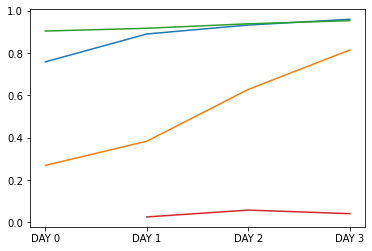

In [636]:
plt.plot(days0,fraction_label)
plt.plot(days0,fraction_leaf)
plt.plot(days0,accuracy_leaf)
plt.plot(days1,change)

#### Functions

In [96]:
def get_performance(DAYS, END, pred, current_pred, index_leaf, index_no_leaf, previous_pred_block, THRESHOLDS, OPTION, CERTAINTY, y_test, Tree, HC, feature_importances, statistics):
    
    #Initialize Dictionary at Day 0
    
    if DAYS == 0:
        statistics = {'%classified'     :{}, 'N_classified'         :{},  'N_predicted' : {},
                      'leaf_accuracy'   :{}, 'total_leaf_accuracy'  :{},
                      'leaf_precision'  :{}, 'total_leaf_precision' :{},
                      'leaf_recall'     :{}, 'total_leaf_recall'    :{},
                      'label_precision' :{}, 
                      'label_recall'    :{}, 
                      'block_precision' :{},
                      'block_recall'    :{},
                      'block_Nchange'   :{}, 'block_Pchange'        :{},
                      '%blocking'       :{}, '%Tblocking'           :{},
                      'tree_error'      :{},
                      'thresholds'      :{},
                      'option'          :{},
                      'certainty'       :{}}

        for leaf in Tree._get_leaf_nodes()+Tree._get_internal_nodes(): 
            statistics['precision_'+leaf] = {}
            statistics['recall_'+leaf]    = {}
            statistics['f1_'+leaf]        = {}
            
        feature_importances = pd.DataFrame(index = X_col)
        decision_trees = {}
    
    #Get Daily information
    
    check_block = pred.isin(Tree._get_internal_nodes())
    index_block = check_block[check_block].index        
        
    total_check_leaf = current_pred.isin(Tree._get_leaf_nodes())   #of all predictions which are now leaf
    total_index_leaf = total_check_leaf[total_check_leaf].index
        
    if DAYS > 0:
        block = pd.concat([previous_pred_block, pred.loc[previous_pred_block.index]], axis=1, keys = [0,1])
        block['Nchange'] = block.apply(lambda row: 0 if row[1] in Tree._get_descendants(row[0])+[row[0]] else 1, axis = 1)
        block['Pchange'] = block.apply(lambda row: 1 if row[1] in Tree._get_descendants(row[0]) else 0, axis = 1)
    previous_pred_block = pred.loc[index_block]
    #previous_index_block = index_block

    y_test = y_test['detailedMatchClassification']
    test_pred = pd.concat([y_test.loc[index_leaf], current_pred[index_leaf]], axis=1, keys = [0,1])
    test_pred['TE'] = test_pred.apply(lambda row: Tree._tree_distance(row[0], row[1]), axis = 1)
    
    #Update Dictionary
    
    statistics['option'][DAYS]          = OPTION
    statistics['certainty'][DAYS]       = CERTAINTY
    statistics['thresholds'][DAYS]      = THRESHOLDS
    statistics['%classified'][DAYS]     = current_pred.isin(Tree._get_leaf_nodes()).sum() / len(y_test)
    statistics['N_classified'][DAYS]    = int(len(index_leaf))
    statistics['N_predicted'][DAYS]     = int(len(pred))

    statistics['leaf_accuracy'][DAYS]   = metrics.accuracy_score(y_test.loc[index_leaf], pred.loc[index_leaf])
    statistics['leaf_precision'][DAYS]  = precision_score_ancestors(Tree, y_test.loc[index_leaf], pred.loc[index_leaf])
    statistics['leaf_recall'][DAYS]     = recall_score_ancestors(Tree, y_test.loc[index_leaf], pred.loc[index_leaf])

    for leaf in Tree._get_leaf_nodes()+Tree._get_internal_nodes():
        leaf_ix = pred.loc[pred == leaf].index
        statistics['precision_'+leaf][DAYS] = precision_score_ancestors(Tree, y_test.loc[leaf_ix], pred.loc[leaf_ix])
        statistics['recall_'+leaf][DAYS]    = recall_score_ancestors(Tree, y_test.loc[leaf_ix], pred.loc[leaf_ix])
        statistics['f1_'+leaf][DAYS]        = f1_score_ancestors(Tree, y_test.loc[leaf_ix], pred.loc[leaf_ix], beta = 1)
        
    for clf in list(HC.stages.keys()):
        if isinstance(HC.stages[clf]['classifier'],RandomForestClassifier):
            feature_importances[clf+'_'+str(DAYS)] = HC.stages[clf]['classifier'].feature_importances_ 
        elif isinstance(HC.stages[clf]['classifier'],LogisticRegression):
            feature_importances[clf+'_'+str(DAYS)] = HC.stages[clf]['classifier'].coef_[0] 

    statistics['total_leaf_accuracy'][DAYS]  = metrics.accuracy_score(y_test.loc[total_index_leaf], current_pred.loc[total_index_leaf])
    statistics['total_leaf_precision'][DAYS] = precision_score_ancestors(Tree, y_test.loc[total_index_leaf], current_pred.loc[total_index_leaf])
    statistics['total_leaf_recall'][DAYS]    = recall_score_ancestors(Tree, y_test.loc[total_index_leaf], current_pred.loc[total_index_leaf])

    statistics['label_precision'][DAYS]  = precision_score_ancestors(Tree, y_test.loc[index_leaf.union(index_block)], pred.loc[index_leaf.union(index_block)]) 
    statistics['label_recall'][DAYS]     = recall_score_ancestors(Tree, y_test.loc[index_leaf.union(index_block)], pred.loc[index_leaf.union(index_block)])  

    statistics['block_precision'][DAYS] = precision_score_ancestors(Tree, y_test.loc[index_block], pred.loc[index_block]) if DAYS < END else None
    statistics['block_recall'][DAYS]    = recall_score_ancestors(Tree, y_test.loc[index_block], pred.loc[index_block]) if DAYS < END else None
    statistics['block_Nchange'][DAYS]   = block['Nchange'].sum() / block['Nchange'].count() if DAYS > 0 else None
    statistics['block_Pchange'][DAYS]   = block['Pchange'].sum() / block['Pchange'].count() if DAYS > 0 else None
    statistics['%blocking'][DAYS]       = HC.blocking  if len(total_index_leaf) != len(y_test) else {'ORDERS':None,'KNOWN':None,'UNHAPPY':None}
    statistics['%Tblocking'][DAYS]      = HC.Tblocking if len(total_index_leaf) != len(y_test) else {'ORDERS':None,'KNOWN':None,'UNHAPPY':None}

    statistics['tree_error'][DAYS]      = np.mean(test_pred['TE'])
        
    return statistics, feature_importances, previous_pred_block

In [97]:
def global_scores(y_true, y_pred, average = 'macro'):
    accuracy = metrics.accuracy_score(y_true, y_pred)
    scores = metrics.precision_recall_fscore_support(y_true, y_pred, average = average)
    return accuracy, scores[0], scores[1], scores[2]

def local_scores(y_true, y_pred):
    labels = np.unique(y_true)
    scores = metrics.precision_recall_fscore_support(y_true, y_pred, average = None, labels = labels, beta = 1)
    return scores[0], scores[1], scores[2]

def class_report(y_true, y_pred):
    print(metrics.classification_report(y_true, y_pred))

def _aggregate_class_sets(set_function, y_true, y_pred):
    intersection_sum = 0
    true_sum = 0
    predicted_sum = 0
    for true, pred in zip(list(y_true), list(y_pred)):
        true_set = set([true] + set_function(true))
        pred_set = set([pred] + set_function(pred))
        intersection_sum += len(true_set.intersection(pred_set))
        true_sum += len(true_set)
        predicted_sum += len(pred_set)
    return (true_sum, predicted_sum, intersection_sum)

def precision_score_ancestors(class_hierarchy, y_true, y_pred):
    true_sum, predicted_sum, intersection_sum = _aggregate_class_sets(
        class_hierarchy._get_ancestors, y_true, y_pred)
    if predicted_sum == 0:
        return None
    else:
        return intersection_sum / predicted_sum

def recall_score_ancestors(class_hierarchy, y_true, y_pred):
    true_sum, predicted_sum, intersection_sum = _aggregate_class_sets(
        class_hierarchy._get_ancestors, y_true, y_pred)
    if true_sum == 0:
        return None
    else:
        return intersection_sum / true_sum

def f1_score_ancestors(class_hierarchy, y_true, y_pred, beta):
    precision = precision_score_ancestors(class_hierarchy, y_true, y_pred)
    recall = recall_score_ancestors(class_hierarchy, y_true, y_pred)
    if (precision == None) or (recall == None):
        return None
    elif (precision == 0) or (recall == 0):
        return 0
    else:
        return ((beta ** 2 + 1) * precision * recall) / ((beta ** 2 * precision) + recall)

In [98]:
class ClassHierarchy:
    
    def __init__(self, root):
        self.root = root
        self.nodes = {}
        
    def add_node(self, children, parent):
        for child in children:
            self.nodes[child] = parent
            
    def _get_leaf_nodes(self):
        leaf_nodes = []
        for child in self.nodes.keys():
            if self._get_children(child) == []:
                leaf_nodes.append(child)
        return leaf_nodes
    
    def _get_internal_nodes(self):
        internal_nodes = []
        leaves = self._get_leaf_nodes()
        for child in self.nodes.keys():
            if (child != self.root) and (child not in leaves):
                internal_nodes.append(child)
        return internal_nodes

    def _get_children(self, parent):
        return sorted([child for child, childs_parent in
                       self.nodes.items() if childs_parent == parent])
    
    def _get_parent(self, child):
        return self.nodes[child] if (child in self.nodes and child != self.root) else self.root
    
    def _get_ancestors(self, child):
        # Not including root, not including the child
        ancestors = []
        while True:
            child = self._get_parent(child)
            if child == self.root:
                break
            ancestors.append(child)
        return ancestors
    
    def _get_descendants(self, parent):
        # Return a list of the descendants of this node, not including the parent
        descendants = []
        self._depth_first(parent, descendants)
        descendants.remove(parent)
        return descendants
    
    def _depth_first(self, parent, classes):
        classes.append(parent)
        for node in self._get_children(parent):
            self._depth_first(node, classes)
            
    def _tree_distance(self, y_test, pred):
        
        y_test_path = [y_test] + self._get_ancestors(y_test) + [self.root] if y_test != self.root else [y_test] + self._get_ancestors(y_test)
        pred_path   = [pred] + self._get_ancestors(pred) + [self.root] if pred != self.root else [pred] + self._get_ancestors(pred)
        
        y_test_edges = []
        for ix, node in enumerate(y_test_path):
            length = len(y_test_path)
            if ix < length - 1:
                y_test_edges.append((node, y_test_path[ix+1]))
                
        pred_edges = []
        for ix, node in enumerate(pred_path):
            length = len(pred_path)
            if ix < length - 1:
                pred_edges.append((node, pred_path[ix+1]))        
        
        tree_distance = len([edge for edge in y_test_edges + pred_edges if edge not in pred_edges or edge not in y_test_edges])
        
        return tree_distance

In [99]:
class HierarchicalClassifier:

    def __init__(self, class_hierarchy):
        self.stages = {}
        self.class_hierarchy = class_hierarchy
        self._create_stages(self.stages, self.class_hierarchy.root, 0)

    def _create_stages(self, stages, parent, depth):
        # Get the children of this parent
        children = self.class_hierarchy._get_children(parent)
        
        if len(children) > 0:
            stage = {}
            stage['depth'] = depth
            stage['labels'] = children
            stage['classes'] = stage['labels'] + [parent]
            stage['target'] = 'target_stage_' + parent
            stages[parent] = stage

            for node in children:
                self._create_stages(stages, node, depth + 1)
                
    def _recode_label(self, classes, label):

        while label != self.class_hierarchy.root and label not in classes:
            label = self.class_hierarchy._get_parent(label)
        return label
                
    def _prep_data(self, X, y):
        
        Xcols = range(0, X.shape[1])
        Ycol = X.shape[1]
        
        df = pd.concat([X, y], axis=1, ignore_index=True)
        # Create a target column for each stage with the recoded labels
        for stage_name, stage_info in self.stages.items():
            df[stage_info['target']] = pd.DataFrame.apply(df[[Ycol]],
                                    lambda row: self._recode_label(stage_info['classes'], row[Ycol]),
                                    axis=1)
        return df, Xcols
    
    def _label_mapping(self, y_train, stage_name):
        labels = np.unique(y_train)
        int_label_mapping = dict(enumerate(labels))
        label_int_mapping = {y:x for x,y in int_label_mapping.items()}
        self.stages[stage_name]['mapping'] = {'int_label':int_label_mapping,
                                              'label_int':label_int_mapping}
        
    def _class_weights(self, y_train, stage_name):
        class_weights = class_weight.compute_class_weight('balanced',classes = np.unique(y_train),y = y_train)
        class_weights = dict(enumerate(class_weights))
        self.stages[stage_name]['classifier'].set_params(class_weight = class_weights)
    
    def fit_classifiers(self, classifiers):
        """
        Fit a classifier to each stage
        """
        if classifiers.keys() != self.stages.keys():
             raise ValueError('Your assigned classifiers do not match the stages of the hierarchy, fit a classifier to each of: '+self.stages.keys())
        else:
            for stage, classifier in classifiers.items():
                self.stages[stage]['classifier'] = classifier
    
    def fit(self, X, y):
        """
        Build a multi-classifier from training data (X, y).
        """
        df, Xcols = self._prep_data(X, y)
        self.scaler = preprocessing.MinMaxScaler().fit(X)
        
        for stage_name, stage_info in self.stages.items():
            
            dfFilter = df[df[stage_info['target']].isin(stage_info['classes'])]
            
            X_train = dfFilter[Xcols]
            y_train = dfFilter[[stage_info['target']]]
                        
            #warning - no samples to fit for stage
            if isinstance(stage_info['classifier'], KerasClassifier):
                y_train_col = pd.Series(np.ravel(y_train))
                
                self._class_weights(y_train_col, stage_name)
                self._label_mapping(y_train_col, stage_name)

                y_encoded = y_train_col.map(stage_info['mapping']['label_int'])

                if len(stage_info['labels']) > 2:
                    y_dummy = pd.DataFrame(np_utils.to_categorical(y_encoded))
                    y_train_NN = y_dummy
                else:
                    y_train_NN = np.asarray(y_encoded).reshape((-1,1))

                X_scaled = pd.DataFrame(self.scaler.transform(X_train))
                stage_info['classifier'].fit(X_scaled, y_train_NN)
            else:
                stage_info['classifier'] = stage_info['classifier'].fit(X_train, y_train)
            #print('Stage '+stage_name+' succesfully fitted')

        return self
    
    def predict(self, X):
        
        stage_number = 0
        for stage_name, stage_info in self.stages.items():
            
            if stage_name == self.class_hierarchy.root:
                y_hat = pd.DataFrame([self.class_hierarchy.root] * len(X),
                                        columns=[self.class_hierarchy.root],
                                        index=X.index)
            else:
                y_hat[stage_name] = y_hat[list(self.stages.keys())[stage_number - 1]]
            stage_number += 1             
                
            X_test = X[y_hat[stage_name].isin([stage_name])]  #warning - no samples to fit for stage
            
            if X_test.empty:
                continue
            
            if isinstance(stage_info['classifier'], KerasClassifier):
                X_scaled = pd.DataFrame(self.scaler.transform(X_test))
                if len(stage_info['labels']) == 2:
                    y_pred = pd.Series(stage_info['classifier'].predict(X_scaled).flatten()).map(stage_info['mapping']['int_label'])
                else:
                    y_pred = pd.Series(stage_info['classifier'].predict(X_scaled)).map(stage_info['mapping']['int_label'])
                y_hat_stage = pd.DataFrame(y_pred.values, index = X_test.index)
            else:
                y_hat_stage = pd.DataFrame(stage_info['classifier'].predict(X_test), index = X_test.index)
                
            y_hat = y_hat.assign(stage_col = y_hat_stage)
            y_hat.stage_col = y_hat.stage_col.fillna(y_hat[stage_name]) #fill previously predicted labels
            y_hat = y_hat.drop(stage_name, axis=1)
            y_hat = y_hat.rename(columns={'stage_col': stage_name})
            
        return y_hat.iloc[:, y_hat.shape[1] - 1]     
    
    def predict_proba(self, X, threshold = 0.5):
        
        self.blocking = {}
        stage_number = 0
        for stage_name, stage_info in self.stages.items():
            
            if stage_name == self.class_hierarchy.root:
                y_hat = pd.DataFrame([self.class_hierarchy.root] * len(X),
                                        columns=[self.class_hierarchy.root],
                                        index=X.index)
            else:
                y_hat[stage_name] = y_hat[list(self.stages.keys())[stage_number - 1]]
            stage_number += 1             
                
            X_test = X[y_hat[stage_name].isin([stage_name])]  #warning - no samples to fit for stage
            
            if isinstance(stage_info['classifier'], KerasClassifier):
                X_scaled = pd.DataFrame(self.scaler.transform(X_test))
                y_proba = stage_info['classifier'].predict_proba(X_scaled)
                y_classes = list(stage_info['mapping']['int_label'].values())
            else:
                y_proba = stage_info['classifier'].predict_proba(X_test)
                y_classes = stage_info['classifier'].classes_
            
            max_prob = np.amax(y_proba, axis=1)              #max probability of classes
            max_class = np.argmax(y_proba, axis=1)           #class number with max probability
            accept_index = np.where(max_prob >= threshold)[0]#indexes which are above threshold
            accept_class = np.take(max_class, accept_index)  #filtered list of orders which are above threshold
            
            if len(accept_class) > 0: #check if samples reach threshold
                accept_label = np.vectorize(lambda x: y_classes[x])(accept_class)                             #convert class number into label
                y_hat_stage = pd.DataFrame(accept_label, index = np.take(X_test.index.values, accept_index))  #set labels to correct position
                self.blocking[stage_name] = 1 - (len(accept_class) / len(max_class)) #blocking factor
            else:
                y_hat_stage = pd.DataFrame(columns = [0], index = X_test.index)
                self.blocking[stage_name] = 1
                
            y_hat = y_hat.assign(stage_col = y_hat_stage)
            y_hat.stage_col = y_hat.stage_col.fillna(y_hat[stage_name]) #fill previously predicted labels
            y_hat = y_hat.drop(stage_name, axis=1)
            y_hat = y_hat.rename(columns={'stage_col': stage_name})
            
        return y_hat.iloc[:, y_hat.shape[1] - 1]
    
    def predict_proba2(self, X, THRESHOLDS):
        
        self.blocking = {}
        self.Tblocking = {}
        stage_number = 0
        for stage_name, stage_info in self.stages.items():
            
            if stage_name == self.class_hierarchy.root:
                y_hat = pd.DataFrame([self.class_hierarchy.root] * len(X),
                                        columns=[self.class_hierarchy.root],
                                        index=X.index)
            else:
                y_hat[stage_name] = y_hat[list(self.stages.keys())[stage_number - 1]]
            stage_number += 1             
                
            X_test = X[y_hat[stage_name].isin([stage_name])]  #warning - no samples to fit for stage
            
            if X_test.empty:
                self.blocking[stage_name] = None
                self.Tblocking[stage_name] = None
                continue
            
            if isinstance(stage_info['classifier'], KerasClassifier):
                X_scaled = pd.DataFrame(self.scaler.transform(X_test))
                y_proba = stage_info['classifier'].predict_proba(X_scaled)
                y_classes = list(stage_info['mapping']['int_label'].values())
            else:
                y_proba = stage_info['classifier'].predict_proba(X_test)
                y_classes = stage_info['classifier'].classes_
            
            max_prob = np.amax(y_proba, axis=1)              #max probability of classes
            max_class = np.argmax(y_proba, axis=1)           #class number with max probability
            max_class_thresholds = np.vectorize(lambda x: THRESHOLDS[y_classes[x]])(max_class)  #get node specific threshold
            
            #print(pd.DataFrame({'max_prob':max_prob,'max_class':max_class,'max_class_thresholds':max_class_thresholds}))
            
            accept_index = np.where(max_prob >= max_class_thresholds)[0]

            accept_class = np.take(max_class, accept_index)  #filtered list of orders which are above threshold
            
            if len(accept_class) > 0: #check if samples reach threshold
                accept_label = np.vectorize(lambda x: y_classes[x])(accept_class)                             #convert class number into label
                y_hat_stage = pd.DataFrame(accept_label, index = np.take(X_test.index.values, accept_index))  #set labels to correct position
                
#                 pja = pd.DataFrame({'max_prob':max_prob,'max_class':np.vectorize(lambda x: y_classes[x])(max_class)})
#                 pja['accept_class'] = pd.Series(data = accept_class, index = accept_index)
#                 print(pja)
                
                self.blocking[stage_name] = 1 - (len(accept_class) / len(max_class)) #blocking factor
                self.Tblocking[stage_name] = len(max_class) - len(accept_class)
            else:
                y_hat_stage = pd.DataFrame(columns = [0], index = X_test.index)
                self.blocking[stage_name] = 1
                self.Tblocking[stage_name] = len(max_class)
                
            y_hat = y_hat.assign(stage_col = y_hat_stage)
            y_hat.stage_col = y_hat.stage_col.fillna(y_hat[stage_name]) #fill previously predicted labels
            y_hat = y_hat.drop(stage_name, axis=1)
            y_hat = y_hat.rename(columns={'stage_col': stage_name})
            
        return y_hat.iloc[:, y_hat.shape[1] - 1]
    
    def get_probabilities(self, X, y):
        
        df, Xcols = self._prep_data(X, y)
        
        stage_number = 0
        
        y_hat = pd.DataFrame(columns = [self.class_hierarchy.root], index = X.index)
        
        for stage_name, stage_info in self.stages.items():
                
            stage_number += 1             
            
            dfFilter = df[df[stage_info['target']].isin(stage_info['classes'])]
            
            X_test = dfFilter[Xcols]
            y_test = dfFilter[[stage_info['target']]]
            
            if isinstance(stage_info['classifier'], KerasClassifier):
                X_scaled = pd.DataFrame(self.scaler.transform(X_test))
                y_proba = stage_info['classifier'].predict_proba(X_scaled)
                y_classes = list(stage_info['mapping']['int_label'].values())
            else:
                y_proba = stage_info['classifier'].predict_proba(X_test)
                y_classes = stage_info['classifier'].classes_
            
            y_hat_stage = pd.DataFrame(y_proba, index = X_test.index)

            for col, label in enumerate(y_classes):
                y_hat[label] = y_hat_stage[col]
               
        return y_hat

In [100]:
def get_probs(day):
    HC = HierarchicalClassifier(ch)
    HC.fit_classifiers({'ORDERS'  : DecisionTreeClassifier(random_state=0, class_weight='balanced', criterion = hypers.loc[day, '1_criterion'], max_depth = hypers.loc[day, '1_max_depth']),
                        'KNOWN'   : DecisionTreeClassifier(random_state=0, class_weight='balanced', criterion = hypers.loc[day, '2_criterion'], max_depth = hypers.loc[day, '2_max_depth']),
                        'UNHAPPY' : RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = hypers.loc[day, '3_max_depth'], n_estimators = hypers.loc[day, '3_n_estimators'])})
    
    X, y  = functions.dataX(df_, DATE, X_col, Y_col, historic_variable, day)
    index = range(0, X.shape[0])

    X_train, X_test, y_train, y_test, ix_train, ix_test = train_test_split(X, y, index, test_size=0.2, random_state=0, shuffle=False)

    HC.fit(X_train,y_train)
    y_hat = HC.get_probabilities(X_train, y_train)

    probs = pd.concat([y_train, y_hat], axis=1)
    
    return(probs)

def opt_threshold(probs, node, day, certainty, option, steps = 100):
    
    if node == 1:
        probabilities_for = 'UNKNOWN'
        y_pos_filter_list = ['UNKNOWN']
        y_neg_filter_list = ['HAPPY', 'MILDLY UNHAPPY', 'MEDIUM UNHAPPY', 'HEAVILY UNHAPPY']
        level             = probs[['UNKNOWN', 'KNOWN']]
        majority_vote     = level[level['UNKNOWN'] > level['KNOWN']]['UNKNOWN']
    elif node == 2:
        probabilities_for = 'KNOWN'
        y_pos_filter_list = ['HAPPY', 'MILDLY UNHAPPY', 'MEDIUM UNHAPPY', 'HEAVILY UNHAPPY']
        y_neg_filter_list = ['UNKNOWN']
        level             = probs[['UNKNOWN', 'KNOWN']]
        majority_vote     = level[level['KNOWN'] > level['UNKNOWN']]['KNOWN']
    elif node == 3:
        probabilities_for = 'HAPPY'
        y_pos_filter_list = ['HAPPY']
        y_neg_filter_list = ['MILDLY UNHAPPY', 'MEDIUM UNHAPPY', 'HEAVILY UNHAPPY']
        level             = probs[probs.detailedMatchClassification.isin(['MILDLY UNHAPPY', 'MEDIUM UNHAPPY', 'HEAVILY UNHAPPY', 'HAPPY'])][['UNHAPPY', 'HAPPY']]
        majority_vote     = level[level['HAPPY'] > level['UNHAPPY']]['HAPPY']
    elif node == 4:
        probabilities_for = 'UNHAPPY'
        y_pos_filter_list = ['MILDLY UNHAPPY', 'MEDIUM UNHAPPY', 'HEAVILY UNHAPPY']
        y_neg_filter_list = ['HAPPY']
        level             = probs[probs.detailedMatchClassification.isin(['MILDLY UNHAPPY', 'MEDIUM UNHAPPY', 'HEAVILY UNHAPPY', 'HAPPY'])][['UNHAPPY', 'HAPPY']]
        majority_vote     = level[level['UNHAPPY'] > level['HAPPY']]['UNHAPPY']
    elif node == 5:
        probabilities_for = 'MILDLY UNHAPPY'
        y_pos_filter_list = ['MILDLY UNHAPPY']
        y_neg_filter_list = ['MEDIUM UNHAPPY', 'HEAVILY UNHAPPY']
        level             = probs[probs.detailedMatchClassification.isin(['MILDLY UNHAPPY', 'MEDIUM UNHAPPY', 'HEAVILY UNHAPPY'])][['MILDLY UNHAPPY', 'MEDIUM UNHAPPY', 'HEAVILY UNHAPPY']]
        majority_vote     = level[ (level['MILDLY UNHAPPY'] > level['MEDIUM UNHAPPY']) & (level['MILDLY UNHAPPY'] > level['HEAVILY UNHAPPY']) ]['MILDLY UNHAPPY']
    elif node == 6:
        probabilities_for = 'MEDIUM UNHAPPY'
        y_pos_filter_list = ['MEDIUM UNHAPPY']
        y_neg_filter_list = ['MILDLY UNHAPPY', 'HEAVILY UNHAPPY']
        level             = probs[probs.detailedMatchClassification.isin(['MILDLY UNHAPPY', 'MEDIUM UNHAPPY', 'HEAVILY UNHAPPY'])][['MILDLY UNHAPPY', 'MEDIUM UNHAPPY', 'HEAVILY UNHAPPY']]
        majority_vote     = level[ (level['MEDIUM UNHAPPY'] > level['MILDLY UNHAPPY']) & (level['MEDIUM UNHAPPY'] > level['HEAVILY UNHAPPY']) ]['MEDIUM UNHAPPY']
    elif node == 7:
        probabilities_for = 'HEAVILY UNHAPPY'
        y_pos_filter_list = ['HEAVILY UNHAPPY']
        y_neg_filter_list = ['MILDLY UNHAPPY', 'MEDIUM UNHAPPY']
        level             = probs[probs.detailedMatchClassification.isin(['MILDLY UNHAPPY', 'MEDIUM UNHAPPY', 'HEAVILY UNHAPPY'])][['MILDLY UNHAPPY', 'MEDIUM UNHAPPY', 'HEAVILY UNHAPPY']]
        majority_vote     = level[ (level['HEAVILY UNHAPPY'] > level['MEDIUM UNHAPPY']) & (level['HEAVILY UNHAPPY'] > level['MILDLY UNHAPPY']) ]['HEAVILY UNHAPPY']
    else:
        raise Exception('''Error: undefined node has been passed. Node options (integer input):
                           1: Unknown
                           2: Known
                           3: Happy
                           4: Unhappy
                           5: Mildly Unhappy
                           6: Medium Unhappy
                           7: Heavily Unhappy''')
    
    y_pos = probs[probs.detailedMatchClassification.isin(y_pos_filter_list)][probabilities_for] 
    y_neg = probs[probs.detailedMatchClassification.isin(y_neg_filter_list)][probabilities_for]
    
    if option == 1:
        y_pos = y_pos[y_pos > min(majority_vote)]
        y_neg = y_neg[y_neg > min(majority_vote)]
    elif option == 2:
        y_pos = y_pos[y_pos.index.isin(majority_vote.index)]
        y_neg = y_neg[y_neg.index.isin(majority_vote.index)]
    else:
        raise Exception('''Error: undefined threshold option has been passed. Threshold options (integer input):
                           1: Consider all probabilities >= min(majority vote)
                           2: Only consider probabilities that are the majority vote''')
    
#     y_pos = probs[probs.detailedMatchClassification.isin(y_pos_filter_list)]#[probabilities_for]
#     y_pos = y_pos[y_pos[probabilities_for] > boundary][probabilities_for]
#     y_pos = y_pos.sort_values()
#     y_pos = y_pos.reset_index(drop = True)  

#     y_neg = probs[probs.detailedMatchClassification.isin(y_neg_filter_list)]#[probabilities_for]
#     y_neg = y_neg[y_neg[probabilities_for] > boundary][probabilities_for]
#     y_neg = y_neg.sort_values()
#     y_neg = y_neg.reset_index(drop = True)
    
    # Potential thresholds
    V = np.concatenate((y_pos, y_neg))
#    V = np.append(V, 0.5)
    V = np.unique(V) # np.unique() also sorts
    #print('V unique:',V)
    
    #V = V[0:(len(V)-1)] #discard the highest probability as option, putting that as threshold is nonsensical since criterion is 'probability > threshold'
    #V = V[V >= max(lowerbound, 0.5)] #define allowed search space
    #V_length = len(V) 
    
    if len(y_neg) > 0:
        lowerbound = np.percentile(y_neg, (certainty*100))
    else:
        lowerbound = V.min()
    
    V = V[V >= lowerbound] #define allowed search space
    #print('V > lowerbound:',V)
    
    #steps = math.floor((V.max() - V.min()) / stepsize)  OLD -> ERROR
    #S = np.linspace(V.min(), V.max(), steps)            OLD -> ERROR
    
    S = np.linspace(V.min(), V.max(), steps)
    
    #print('S:',S)
    
    thresholds = pd.DataFrame({'threshold'     : [0]*steps,
                               'F_score'       : [0]*steps})
#                                'perc_rejected' : [0]*steps,
#                                'perc_accepted' : [0]*steps,
#                                'count_rejected': [0]*steps,
#                                'count_accepted': [0]*steps})
    #print('thresholds pre:',thresholds)
    
#     thresholds = pd.DataFrame({'threshold'      : [0]*V_length,
#                                'F_score'        : [0]*V_length})
    
    for i in range(steps):        
        threshold = S[i]       
#         threshold = V[i] 
        beta      = 1
        positives = len(y_pos[y_pos >= threshold])  #CHANGED > into >=
        negatives = len(y_neg[y_neg >= threshold])  #CHANGED > into >=
        recall    = positives / len(y_pos)
        precision = positives / (positives + negatives)

        thresholds.loc[i, 'threshold']       = threshold
        thresholds.loc[i, 'F_score']         = ((beta ** 2 + 1) * precision * recall) / ((beta ** 2 * precision) + recall) if ((beta ** 2 * precision) + recall) != 0 else 0
        
    #print('thresholds post:',thresholds)
        
    F_score         = thresholds['F_score'].max()
    opt_index       = thresholds['F_score'].argmax()
    threshold       = thresholds.loc[opt_index, 'threshold']
    
    return(probabilities_for, threshold)

def flat_thresholds(probs, node, day, certainty, steps = 100):
    
    NODES = set(['UNKNOWN', 'HAPPY', 'MILDLY UNHAPPY', 'MEDIUM UNHAPPY', 'HEAVILY UNHAPPY'])
    
    if node == 1:   NODE = 'UNKNOWN'
    elif node == 2: NODE = 'HAPPY'
    elif node == 3: NODE = 'MILDLY UNHAPPY'
    elif node == 4: NODE = 'MEDIUM UNHAPPY'
    elif node == 5: NODE = 'HEAVILY UNHAPPY'
    else:
        raise Exception('''Error: undefined node has been passed. Node options (integer input):
                           1: Unknown
                           2: Happy
                           3: Mildly Unhappy
                           4: Medium Unhappy
                           5: Heavily Unhappy''')
        
    probabilities_for = NODE
    y_pos_filter_list = [NODE]
    y_neg_filter_list = list(NODES - {NODE})
    majority_vote     = probs[probs[NODE] > probs[list(NODES - {NODE})].max(axis=1)][NODE]
        
    y_pos = probs[probs.detailedMatchClassification.isin(y_pos_filter_list)][probabilities_for] 
    y_neg = probs[probs.detailedMatchClassification.isin(y_neg_filter_list)][probabilities_for]
    
    y_pos = y_pos[y_pos.index.isin(majority_vote.index)]
    y_neg = y_neg[y_neg.index.isin(majority_vote.index)]
 
    if len(y_neg) > 0:
        lowerbound = np.percentile(y_neg, (certainty*100))
    else:
        lowerbound = V.min()
    
    # Potential thresholds
    V = np.concatenate((y_pos, y_neg))
    V = np.unique(V) # np.unique() also sorts    
    V = V[V >= lowerbound] #define allowed search space
    S = np.linspace(V.min(), V.max(), steps)
    
    thresholds = pd.DataFrame({'threshold'     : [0]*steps,
                               'F_score'       : [0]*steps})
    
    for i in range(steps):        
        threshold = S[i] 
        beta      = 1
        positives = len(y_pos[y_pos >= threshold])
        negatives = len(y_neg[y_neg >= threshold])
        recall    = positives / len(y_pos)
        precision = positives / (positives + negatives)

        thresholds.loc[i, 'threshold']       = threshold
        thresholds.loc[i, 'F_score']         = ( (1 + (beta**2)) * precision * recall ) / ( (beta**2) * precision + recall ) if ( (beta**2) * precision + recall ) != 0 else 0
        
    
    F_score         = thresholds['F_score'].max()
    opt_index       = thresholds['F_score'].argmax()
    threshold       = thresholds.loc[opt_index, 'threshold']                           

    return(probabilities_for, threshold)